[tensorboard](http://condor:6006)

N - number of data points ('examples')   
D - dimensionality of input data   
K - dimensionality of principal component space
  
x1 - noisy data   
x - noiseless (in case of toy) or complete (in case of real) date

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from collections import Counter

In [6]:
import sys
sys.path.append('../python/')

from pca import core, tests
from plots import availability_matrix as avail

In [5]:
from IPython.display import set_matplotlib_formats
%matplotlib inline

set_matplotlib_formats('png', 'pdf')

## Data

In [8]:
t = tests.Data().real()

FileNotFoundError: File ../../data/CEAZAMet/station_data.h5 does not exist

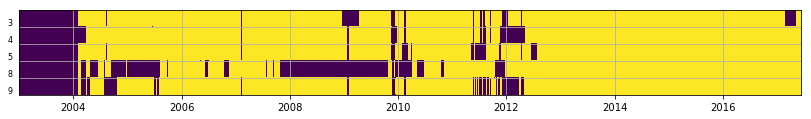

In [41]:
avail(t.mask, figsize=(14, 2), bottom=.4)

Temporal distribution of temperature measurements at five CEAZAMet stations (rows).

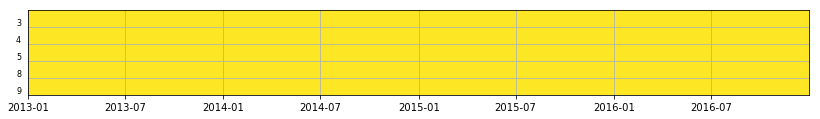

In [26]:
avail(t.x.notnull(), figsize=(14, 2), bottom=.4)

The part of the time series that doesn't have *any* missing values. (**Check frequency / spacing**)

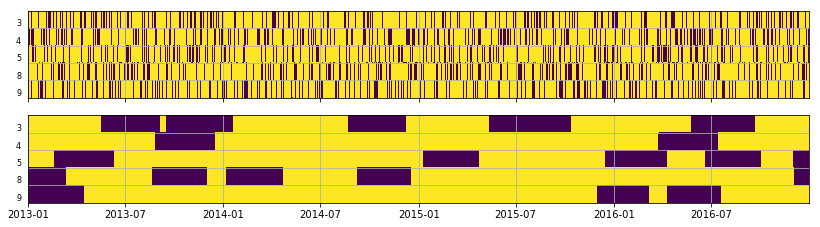

In [45]:
fig, axs = plt.subplots(2, 1, figsize=(14, 3))
t.missing(.3)
avail(t.mask, axs[0])
t.missing(.3, 20)
avail(t.mask, axs[1], bottom=.1)
axs[0].set_xticklabels([]);

Two different ways of generating missing values: **TOP**: missing values inserted at random with a uniform distribution over the length of the record. **Bottom**: in blocks whose length is drawn from a Poisson distribution with mean rate (total length / number of blocks) and location of block start uniformly distributed over the total length.

In [61]:
from imp import reload

In [944]:
d = data().toy()

In [390]:
p1 = ppca.detPCA()
for mv in np.linspace(0, 1, 20):
    p1.run(d.missing(mv).x1).critique(d)

In [394]:
p2 = ppca.detPCA()
for mv in np.linspace(0, 1, 20):
    p2.run(d.missing(mv).x1, n_iter=10).critique(d)

<IPython.core.display.Javascript object>


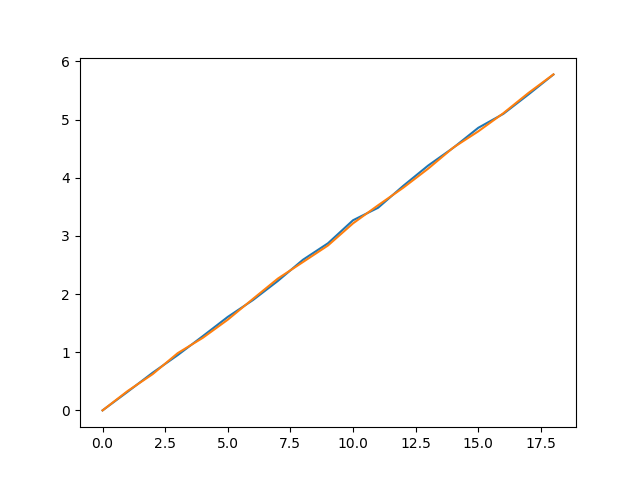

In [395]:
plt.figure()
plt.plot(p1.losses.x)
plt.plot(p2.losses.x)

In [430]:
ppca.tf.get_variable_scope().reuse_variables()

## Experiments

### Toy data

#### Experiment 1

* 0% missing
* 10 different toy data sets
* 10 different random seeds for probabilistic

In [979]:
n_data = 10
n_seed = 10
n_iter = 2000

for _ in range(n_data):
    d = tests.data().toy()
    p2 = pca.detPCA().run(d.x1).critique(d)
    for s in range(n_pca_init):
        p1 = ppca.probPCA(d.x1, seed=s, logdir='ppca_logs')
        p1.run(n_iter).critique(d)
        p1.critique(d, rotate=True)


data_loss: nan
tau: nan
alpha: nan


../python/ppca.py:75: UserWarning: Attempted to access non-existing variable.
  warn('Attempted to access non-existing variable.')


2000/2000 [100%] ██████████████████████████████ Elapsed: 14s | Loss: 57345.992

data_loss: 0.691728413105011
tau: 1.2204903364181519
alpha: nan

data_loss: 0.691728413105011
tau: 1.2204903364181519
alpha: nan
2000/2000 [100%] ██████████████████████████████ Elapsed: 14s | Loss: 57395.676

data_loss: 0.5998782515525818
tau: 1.1857703924179077
alpha: nan

data_loss: 0.5998782515525818
tau: 1.1857703924179077
alpha: nan
2000/2000 [100%] ██████████████████████████████ Elapsed: 14s | Loss: 57628.5311s |

data_loss: 0.7146548628807068
tau: 1.3035848140716553
alpha: nan

data_loss: 0.7146548628807068
tau: 1.3035848140716553
alpha: nan
2000/2000 [100%] ██████████████████████████████ Elapsed: 15s | Loss: 58676.434

data_loss: 0.433280348777771
tau: 1.164991021156311
alpha: nan

data_loss: 0.433280348777771
tau: 1.164991021156311
alpha: nan
2000/2000 [100%] ██████████████████████████████ Elapsed: 15s | Loss: 57573.941

data_loss: 0.7073445916175842
tau: 1.284693717956543
alpha: nan

data_loss: 0.

2000/2000 [100%] ██████████████████████████████ Elapsed: 14s | Loss: 53643.789

data_loss: 0.38285475969314575
tau: 1.0106867551803589
alpha: nan

data_loss: 0.38285475969314575
tau: 1.0106867551803589
alpha: nan
2000/2000 [100%] ██████████████████████████████ Elapsed: 18s | Loss: 53873.984

data_loss: 0.5102159976959229
tau: 1.1512508392333984
alpha: nan

data_loss: 0.5102159976959229
tau: 1.1512508392333984
alpha: nan
2000/2000 [100%] ██████████████████████████████ Elapsed: 14s | Loss: 53657.258

data_loss: 0.3809894025325775
tau: 1.0147093534469604
alpha: nan

data_loss: 0.3809894025325775
tau: 1.0147093534469604
alpha: nan
2000/2000 [100%] ██████████████████████████████ Elapsed: 14s | Loss: 53716.004

data_loss: 0.38076743483543396
tau: 1.0107982158660889
alpha: nan

data_loss: 0.38076743483543396
tau: 1.0107982158660889
alpha: nan

data_loss: nan
tau: nan
alpha: nan
2000/2000 [100%] ██████████████████████████████ Elapsed: 14s | Loss: 53653.906

data_loss: 0.45629942417144775
tau: 

In [7]:
S = pd.HDFStore('./ppca_logs/ppca_experiments.h5')

In [9]:
S.keys()

['/exp1', '/exp1vb', '/exp2', '/exp3']

In [81]:
loss = pd.concat((S['exp1'], S['exp1vb']), 0).replace('None', np.nan)

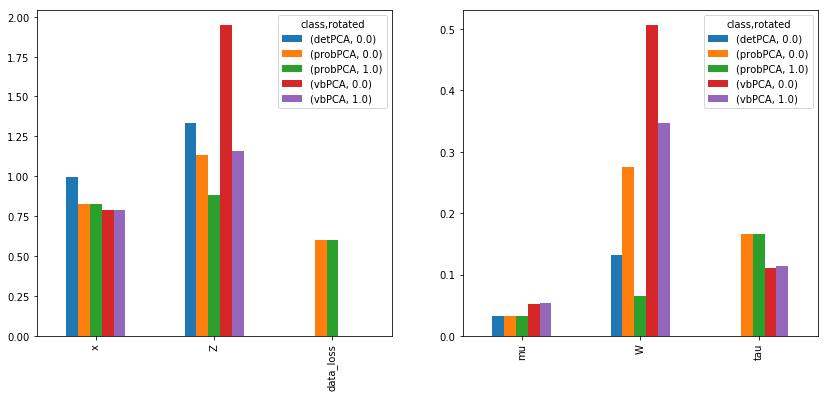

In [86]:
a = loss.groupby(['class', 'rotated']).mean()

fig, axs = plt.subplots(1, 2, figsize=(14, 6))
a[['x', 'Z', 'data_loss']].T.plot.bar(ax=axs[0])
a[['mu', 'W', 'tau']].T.plot.bar(ax=axs[1])

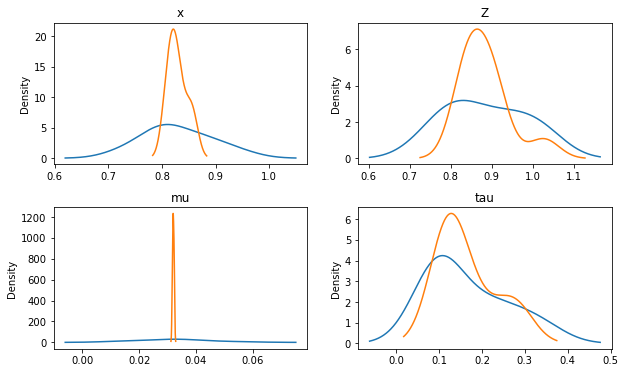

In [993]:
# Only the rotated, probabilistic results
b = loss[(loss['class']=='probPCA') & (loss['rotated']==True)]

fig, axs = plt.subplots(2, 2, figsize=(10, 6))
fig.subplots_adjust(hspace=.3)
b.groupby('data').mean()['x'].plot.kde(ax=axs[0, 0], title='x')
b.groupby('seed').mean()['x'].plot.kde(ax=axs[0, 0])
b.groupby('data').mean()['Z'].plot.kde(ax=axs[0, 1], title='Z')
b.groupby('seed').mean()['Z'].plot.kde(ax=axs[0, 1])
b.groupby('data').mean()['mu'].plot.kde(ax=axs[1, 0], title='mu')
b.groupby('seed').mean()['mu'].plot.kde(ax=axs[1, 0])
b.groupby('data').mean()['tau'].plot.kde(ax=axs[1, 1], title='tau')
b.groupby('seed').mean()['tau'].plot.kde(ax=axs[1, 1]);

The result distribution from random initializations of the probabilistic algorithm (**orange**) is generally much more pointed than that resulting from different random toy data (**blue**). Does the slight hint of a bi- or multi-modality arise from non-uniqueness of the solutions?

In [68]:
n_data = 10
n_seed = 10
n_iter = 100

for i in range(n_data):
    d = tests.data().toy()
    for j in range(n_seed):
        p1 = pca.vbPCA(d.x1).critique(d)
        p2 = pca.vbPCA(d.x1, rotate=True).critique(d)
        
with pd.HDFStore('./ppca_logs/ppca_experiments.f5') as S:
    S['exp1vb']=p1.losses

Iteration 1: loglike=-6.197064e+04 (0.394 seconds)
Iteration 2: loglike=-5.549284e+04 (0.435 seconds)
Iteration 3: loglike=-5.425797e+04 (0.436 seconds)
Iteration 4: loglike=-5.384714e+04 (0.420 seconds)
Iteration 5: loglike=-5.363688e+04 (0.428 seconds)
Iteration 6: loglike=-5.349960e+04 (0.426 seconds)
Iteration 7: loglike=-5.340069e+04 (0.430 seconds)
Iteration 8: loglike=-5.332648e+04 (0.422 seconds)
Iteration 9: loglike=-5.326970e+04 (0.416 seconds)
Iteration 10: loglike=-5.322578e+04 (0.419 seconds)
Iteration 11: loglike=-5.319154e+04 (0.433 seconds)
Iteration 12: loglike=-5.316470e+04 (0.416 seconds)
Iteration 13: loglike=-5.314355e+04 (0.414 seconds)
Iteration 14: loglike=-5.312679e+04 (0.416 seconds)
Iteration 15: loglike=-5.311345e+04 (0.416 seconds)
Iteration 16: loglike=-5.310276e+04 (0.415 seconds)
Iteration 17: loglike=-5.309414e+04 (0.417 seconds)
Iteration 18: loglike=-5.308715e+04 (0.416 seconds)
Iteration 19: loglike=-5.308144e+04 (0.417 seconds)
Iteration 20: loglike

../python/pca/pca.py:79: UserWarning: Attempted to access non-existing variable.
  warn('Attempted to access non-existing variable.')


Iteration 1: loglike=-5.950055e+04 (0.444 seconds)
Iteration 2: loglike=-5.451085e+04 (0.651 seconds)
Iteration 3: loglike=-5.391247e+04 (0.652 seconds)
Iteration 4: loglike=-5.367841e+04 (0.659 seconds)
Iteration 5: loglike=-5.354320e+04 (0.652 seconds)
Iteration 6: loglike=-5.344310e+04 (0.657 seconds)
Iteration 7: loglike=-5.336152e+04 (0.653 seconds)
Iteration 8: loglike=-5.329421e+04 (0.664 seconds)
Iteration 9: loglike=-5.324207e+04 (0.668 seconds)
Iteration 10: loglike=-5.320047e+04 (0.651 seconds)
Iteration 11: loglike=-5.316773e+04 (0.664 seconds)
Iteration 12: loglike=-5.314180e+04 (0.652 seconds)
Iteration 13: loglike=-5.312132e+04 (0.663 seconds)
Iteration 14: loglike=-5.310503e+04 (0.652 seconds)
Iteration 15: loglike=-5.309207e+04 (0.656 seconds)
Iteration 16: loglike=-5.308169e+04 (0.626 seconds)
Iteration 17: loglike=-5.307333e+04 (0.652 seconds)
Iteration 18: loglike=-5.306656e+04 (0.652 seconds)
Iteration 19: loglike=-5.306102e+04 (0.655 seconds)
Iteration 20: loglike

../python/pca/pca.py:79: UserWarning: Attempted to access non-existing variable.
  warn('Attempted to access non-existing variable.')


Iteration 1: loglike=-6.315758e+04 (0.604 seconds)
Iteration 2: loglike=-5.632175e+04 (0.414 seconds)
Iteration 3: loglike=-5.453500e+04 (0.416 seconds)
Iteration 4: loglike=-5.393836e+04 (0.415 seconds)
Iteration 5: loglike=-5.367052e+04 (0.414 seconds)
Iteration 6: loglike=-5.351632e+04 (0.418 seconds)
Iteration 7: loglike=-5.341324e+04 (0.414 seconds)
Iteration 8: loglike=-5.333869e+04 (0.420 seconds)
Iteration 9: loglike=-5.328243e+04 (0.414 seconds)
Iteration 10: loglike=-5.323896e+04 (0.414 seconds)
Iteration 11: loglike=-5.320488e+04 (0.415 seconds)
Iteration 12: loglike=-5.317790e+04 (0.417 seconds)
Iteration 13: loglike=-5.315638e+04 (0.414 seconds)
Iteration 14: loglike=-5.313911e+04 (0.426 seconds)
Iteration 15: loglike=-5.312516e+04 (0.413 seconds)
Iteration 16: loglike=-5.311382e+04 (0.414 seconds)
Iteration 17: loglike=-5.310455e+04 (0.411 seconds)
Iteration 18: loglike=-5.309692e+04 (0.415 seconds)
Iteration 19: loglike=-5.309062e+04 (0.457 seconds)
Iteration 20: loglike

../python/pca/pca.py:79: UserWarning: Attempted to access non-existing variable.
  warn('Attempted to access non-existing variable.')


Iteration 1: loglike=-6.334267e+04 (0.599 seconds)
Iteration 2: loglike=-5.629903e+04 (0.423 seconds)
Iteration 3: loglike=-5.441585e+04 (0.416 seconds)
Iteration 4: loglike=-5.386493e+04 (0.415 seconds)
Iteration 5: loglike=-5.364149e+04 (0.414 seconds)
Iteration 6: loglike=-5.351082e+04 (0.411 seconds)
Iteration 7: loglike=-5.341944e+04 (0.409 seconds)
Iteration 8: loglike=-5.335082e+04 (0.420 seconds)
Iteration 9: loglike=-5.329756e+04 (0.410 seconds)
Iteration 10: loglike=-5.325542e+04 (0.409 seconds)
Iteration 11: loglike=-5.322166e+04 (0.410 seconds)
Iteration 12: loglike=-5.319433e+04 (0.411 seconds)
Iteration 13: loglike=-5.317204e+04 (0.429 seconds)
Iteration 14: loglike=-5.315374e+04 (0.409 seconds)
Iteration 15: loglike=-5.313861e+04 (0.415 seconds)
Iteration 16: loglike=-5.312604e+04 (0.409 seconds)
Iteration 17: loglike=-5.311552e+04 (0.410 seconds)
Iteration 18: loglike=-5.310669e+04 (0.412 seconds)
Iteration 19: loglike=-5.309923e+04 (0.412 seconds)
Iteration 20: loglike

../python/pca/pca.py:79: UserWarning: Attempted to access non-existing variable.
  warn('Attempted to access non-existing variable.')


Iteration 1: loglike=-6.483016e+04 (0.607 seconds)
Iteration 2: loglike=-5.581128e+04 (0.417 seconds)
Iteration 3: loglike=-5.421589e+04 (0.420 seconds)
Iteration 4: loglike=-5.376325e+04 (0.416 seconds)
Iteration 5: loglike=-5.355523e+04 (0.415 seconds)
Iteration 6: loglike=-5.343070e+04 (0.427 seconds)
Iteration 7: loglike=-5.334583e+04 (0.415 seconds)
Iteration 8: loglike=-5.328392e+04 (0.416 seconds)
Iteration 9: loglike=-5.323709e+04 (0.415 seconds)
Iteration 10: loglike=-5.320092e+04 (0.416 seconds)
Iteration 11: loglike=-5.317267e+04 (0.436 seconds)
Iteration 12: loglike=-5.315044e+04 (0.415 seconds)
Iteration 13: loglike=-5.313285e+04 (0.415 seconds)
Iteration 14: loglike=-5.311887e+04 (0.415 seconds)
Iteration 15: loglike=-5.310769e+04 (0.413 seconds)
Iteration 16: loglike=-5.309872e+04 (0.414 seconds)
Iteration 17: loglike=-5.309148e+04 (0.418 seconds)
Iteration 18: loglike=-5.308560e+04 (0.438 seconds)
Iteration 19: loglike=-5.308080e+04 (0.415 seconds)
Iteration 20: loglike

../python/pca/pca.py:79: UserWarning: Attempted to access non-existing variable.
  warn('Attempted to access non-existing variable.')


Iteration 1: loglike=-6.240913e+04 (0.594 seconds)
Iteration 2: loglike=-5.565096e+04 (0.415 seconds)
Iteration 3: loglike=-5.432586e+04 (0.416 seconds)
Iteration 4: loglike=-5.387226e+04 (0.416 seconds)
Iteration 5: loglike=-5.364885e+04 (0.414 seconds)
Iteration 6: loglike=-5.351103e+04 (0.415 seconds)
Iteration 7: loglike=-5.341446e+04 (0.416 seconds)
Iteration 8: loglike=-5.334212e+04 (0.426 seconds)
Iteration 9: loglike=-5.328608e+04 (0.414 seconds)
Iteration 10: loglike=-5.324196e+04 (0.416 seconds)
Iteration 11: loglike=-5.320692e+04 (0.414 seconds)
Iteration 12: loglike=-5.317899e+04 (0.415 seconds)
Iteration 13: loglike=-5.315665e+04 (0.463 seconds)
Iteration 14: loglike=-5.313874e+04 (0.415 seconds)
Iteration 15: loglike=-5.312434e+04 (0.416 seconds)
Iteration 16: loglike=-5.311273e+04 (0.415 seconds)
Iteration 17: loglike=-5.310333e+04 (0.415 seconds)
Iteration 18: loglike=-5.309568e+04 (0.418 seconds)
Iteration 19: loglike=-5.308942e+04 (0.415 seconds)
Iteration 20: loglike

../python/pca/pca.py:79: UserWarning: Attempted to access non-existing variable.
  warn('Attempted to access non-existing variable.')


Iteration 1: loglike=-6.512890e+04 (0.574 seconds)
Iteration 2: loglike=-5.637115e+04 (0.414 seconds)
Iteration 3: loglike=-5.449975e+04 (0.420 seconds)
Iteration 4: loglike=-5.393864e+04 (0.420 seconds)
Iteration 5: loglike=-5.368304e+04 (0.421 seconds)
Iteration 6: loglike=-5.352912e+04 (0.420 seconds)
Iteration 7: loglike=-5.342352e+04 (0.421 seconds)
Iteration 8: loglike=-5.334641e+04 (0.422 seconds)
Iteration 9: loglike=-5.328812e+04 (0.422 seconds)
Iteration 10: loglike=-5.324313e+04 (0.419 seconds)
Iteration 11: loglike=-5.320790e+04 (0.418 seconds)
Iteration 12: loglike=-5.318002e+04 (0.421 seconds)
Iteration 13: loglike=-5.315777e+04 (0.421 seconds)
Iteration 14: loglike=-5.313987e+04 (0.424 seconds)
Iteration 15: loglike=-5.312538e+04 (0.423 seconds)
Iteration 16: loglike=-5.311358e+04 (0.424 seconds)
Iteration 17: loglike=-5.310389e+04 (0.424 seconds)
Iteration 18: loglike=-5.309589e+04 (0.424 seconds)
Iteration 19: loglike=-5.308926e+04 (0.421 seconds)
Iteration 20: loglike

../python/pca/pca.py:79: UserWarning: Attempted to access non-existing variable.
  warn('Attempted to access non-existing variable.')


Iteration 1: loglike=-6.427410e+04 (0.615 seconds)
Iteration 2: loglike=-5.657870e+04 (0.413 seconds)
Iteration 3: loglike=-5.469477e+04 (0.427 seconds)
Iteration 4: loglike=-5.400241e+04 (0.415 seconds)
Iteration 5: loglike=-5.370560e+04 (0.415 seconds)
Iteration 6: loglike=-5.354345e+04 (0.464 seconds)
Iteration 7: loglike=-5.343626e+04 (0.417 seconds)
Iteration 8: loglike=-5.335750e+04 (0.415 seconds)
Iteration 9: loglike=-5.329667e+04 (0.425 seconds)
Iteration 10: loglike=-5.324868e+04 (0.414 seconds)
Iteration 11: loglike=-5.321054e+04 (0.420 seconds)
Iteration 12: loglike=-5.318014e+04 (0.415 seconds)
Iteration 13: loglike=-5.315593e+04 (0.420 seconds)
Iteration 14: loglike=-5.313664e+04 (0.437 seconds)
Iteration 15: loglike=-5.312128e+04 (0.414 seconds)
Iteration 16: loglike=-5.310905e+04 (0.417 seconds)
Iteration 17: loglike=-5.309929e+04 (0.415 seconds)
Iteration 18: loglike=-5.309148e+04 (0.413 seconds)
Iteration 19: loglike=-5.308522e+04 (0.418 seconds)
Iteration 20: loglike

Iteration 12: loglike=-5.242820e+04 (0.414 seconds)
Iteration 13: loglike=-5.238263e+04 (0.413 seconds)
Iteration 14: loglike=-5.234643e+04 (0.412 seconds)
Iteration 15: loglike=-5.231746e+04 (0.415 seconds)
Iteration 16: loglike=-5.229412e+04 (0.411 seconds)
Iteration 17: loglike=-5.227520e+04 (0.416 seconds)
Iteration 18: loglike=-5.225978e+04 (0.413 seconds)
Iteration 19: loglike=-5.224716e+04 (0.423 seconds)
Iteration 20: loglike=-5.223680e+04 (0.424 seconds)
Iteration 21: loglike=-5.222827e+04 (0.419 seconds)
Iteration 22: loglike=-5.222123e+04 (0.427 seconds)
Iteration 23: loglike=-5.221541e+04 (0.421 seconds)
Iteration 24: loglike=-5.221059e+04 (0.410 seconds)
Iteration 25: loglike=-5.220659e+04 (0.415 seconds)
Iteration 26: loglike=-5.220327e+04 (0.415 seconds)
Iteration 27: loglike=-5.220050e+04 (0.425 seconds)
Iteration 28: loglike=-5.219820e+04 (0.417 seconds)
Iteration 29: loglike=-5.219627e+04 (0.414 seconds)
Iteration 30: loglike=-5.219465e+04 (0.422 seconds)
Iteration 31

../python/pca/pca.py:79: UserWarning: Attempted to access non-existing variable.
  warn('Attempted to access non-existing variable.')


Iteration 1: loglike=-6.522999e+04 (0.583 seconds)
Iteration 2: loglike=-5.717423e+04 (0.420 seconds)
Iteration 3: loglike=-5.529004e+04 (0.413 seconds)
Iteration 4: loglike=-5.427442e+04 (0.413 seconds)
Iteration 5: loglike=-5.364972e+04 (0.411 seconds)
Iteration 6: loglike=-5.325578e+04 (0.417 seconds)
Iteration 7: loglike=-5.299335e+04 (0.410 seconds)
Iteration 8: loglike=-5.280705e+04 (0.417 seconds)
Iteration 9: loglike=-5.266892e+04 (0.411 seconds)
Iteration 10: loglike=-5.256420e+04 (0.411 seconds)
Iteration 11: loglike=-5.248401e+04 (0.419 seconds)
Iteration 12: loglike=-5.242222e+04 (0.413 seconds)
Iteration 13: loglike=-5.237434e+04 (0.416 seconds)
Iteration 14: loglike=-5.233700e+04 (0.412 seconds)
Iteration 15: loglike=-5.230765e+04 (0.415 seconds)
Iteration 16: loglike=-5.228441e+04 (0.415 seconds)
Iteration 17: loglike=-5.226587e+04 (0.412 seconds)
Iteration 18: loglike=-5.225098e+04 (0.413 seconds)
Iteration 19: loglike=-5.223897e+04 (0.418 seconds)
Iteration 20: loglike

Iteration 10: loglike=-5.232841e+04 (0.413 seconds)
Iteration 11: loglike=-5.229809e+04 (0.417 seconds)
Iteration 12: loglike=-5.227610e+04 (0.419 seconds)
Iteration 13: loglike=-5.225949e+04 (0.415 seconds)
Iteration 14: loglike=-5.224659e+04 (0.416 seconds)
Iteration 15: loglike=-5.223639e+04 (0.416 seconds)
Iteration 16: loglike=-5.222823e+04 (0.415 seconds)
Iteration 17: loglike=-5.222165e+04 (0.419 seconds)
Iteration 18: loglike=-5.221633e+04 (0.417 seconds)
Iteration 19: loglike=-5.221200e+04 (0.419 seconds)
Iteration 20: loglike=-5.220848e+04 (0.426 seconds)
Iteration 21: loglike=-5.220561e+04 (0.420 seconds)
Iteration 22: loglike=-5.220326e+04 (0.430 seconds)
Iteration 23: loglike=-5.220133e+04 (0.443 seconds)
Iteration 24: loglike=-5.219976e+04 (0.417 seconds)
Iteration 25: loglike=-5.219846e+04 (0.414 seconds)
Iteration 26: loglike=-5.219739e+04 (0.425 seconds)
Iteration 27: loglike=-5.219651e+04 (0.425 seconds)
Iteration 28: loglike=-5.219578e+04 (0.511 seconds)
Iteration 29

../python/pca/pca.py:79: UserWarning: Attempted to access non-existing variable.
  warn('Attempted to access non-existing variable.')


Iteration 1: loglike=-6.579682e+04 (0.607 seconds)
Iteration 2: loglike=-5.734771e+04 (0.429 seconds)
Iteration 3: loglike=-5.512361e+04 (0.437 seconds)
Iteration 4: loglike=-5.395105e+04 (0.429 seconds)
Iteration 5: loglike=-5.327167e+04 (0.428 seconds)
Iteration 6: loglike=-5.288541e+04 (0.430 seconds)
Iteration 7: loglike=-5.266311e+04 (0.428 seconds)
Iteration 8: loglike=-5.252902e+04 (0.429 seconds)
Iteration 9: loglike=-5.244312e+04 (0.427 seconds)
Iteration 10: loglike=-5.238481e+04 (0.427 seconds)
Iteration 11: loglike=-5.234328e+04 (0.429 seconds)
Iteration 12: loglike=-5.231257e+04 (0.427 seconds)
Iteration 13: loglike=-5.228921e+04 (0.424 seconds)
Iteration 14: loglike=-5.227106e+04 (0.425 seconds)
Iteration 15: loglike=-5.225674e+04 (0.426 seconds)
Iteration 16: loglike=-5.224528e+04 (0.426 seconds)
Iteration 17: loglike=-5.223604e+04 (0.425 seconds)
Iteration 18: loglike=-5.222853e+04 (0.428 seconds)
Iteration 19: loglike=-5.222240e+04 (0.427 seconds)
Iteration 20: loglike

../python/pca/pca.py:79: UserWarning: Attempted to access non-existing variable.
  warn('Attempted to access non-existing variable.')


Iteration 1: loglike=-7.168239e+04 (0.573 seconds)
Iteration 2: loglike=-5.762553e+04 (0.427 seconds)
Iteration 3: loglike=-5.480468e+04 (0.429 seconds)
Iteration 4: loglike=-5.367943e+04 (0.421 seconds)
Iteration 5: loglike=-5.308374e+04 (0.422 seconds)
Iteration 6: loglike=-5.276499e+04 (0.423 seconds)
Iteration 7: loglike=-5.258664e+04 (0.423 seconds)
Iteration 8: loglike=-5.247905e+04 (0.423 seconds)
Iteration 9: loglike=-5.240886e+04 (0.424 seconds)
Iteration 10: loglike=-5.235997e+04 (0.422 seconds)
Iteration 11: loglike=-5.232426e+04 (0.425 seconds)
Iteration 12: loglike=-5.229730e+04 (0.423 seconds)
Iteration 13: loglike=-5.227650e+04 (0.424 seconds)
Iteration 14: loglike=-5.226020e+04 (0.423 seconds)
Iteration 15: loglike=-5.224730e+04 (0.425 seconds)
Iteration 16: loglike=-5.223700e+04 (0.423 seconds)
Iteration 17: loglike=-5.222873e+04 (0.423 seconds)
Iteration 18: loglike=-5.222206e+04 (0.421 seconds)
Iteration 19: loglike=-5.221666e+04 (0.425 seconds)
Iteration 20: loglike

Iteration 7: loglike=-5.275091e+04 (0.422 seconds)
Iteration 8: loglike=-5.262550e+04 (0.404 seconds)
Iteration 9: loglike=-5.253472e+04 (0.415 seconds)
Iteration 10: loglike=-5.246592e+04 (0.415 seconds)
Iteration 11: loglike=-5.241240e+04 (0.414 seconds)
Iteration 12: loglike=-5.237009e+04 (0.419 seconds)
Iteration 13: loglike=-5.233631e+04 (0.419 seconds)
Iteration 14: loglike=-5.230913e+04 (0.417 seconds)
Iteration 15: loglike=-5.228712e+04 (0.415 seconds)
Iteration 16: loglike=-5.226923e+04 (0.422 seconds)
Iteration 17: loglike=-5.225462e+04 (0.418 seconds)
Iteration 18: loglike=-5.224267e+04 (0.426 seconds)
Iteration 19: loglike=-5.223287e+04 (0.414 seconds)
Iteration 20: loglike=-5.222483e+04 (0.415 seconds)
Iteration 21: loglike=-5.221822e+04 (0.416 seconds)
Iteration 22: loglike=-5.221278e+04 (0.413 seconds)
Iteration 23: loglike=-5.220829e+04 (0.418 seconds)
Iteration 24: loglike=-5.220458e+04 (0.425 seconds)
Iteration 25: loglike=-5.220150e+04 (0.416 seconds)
Iteration 26: l

../python/pca/pca.py:79: UserWarning: Attempted to access non-existing variable.
  warn('Attempted to access non-existing variable.')


Iteration 1: loglike=-6.391192e+04 (0.624 seconds)
Iteration 2: loglike=-5.631675e+04 (0.431 seconds)
Iteration 3: loglike=-5.483065e+04 (0.426 seconds)
Iteration 4: loglike=-5.440133e+04 (0.421 seconds)
Iteration 5: loglike=-5.424495e+04 (0.414 seconds)
Iteration 6: loglike=-5.414794e+04 (0.516 seconds)
Iteration 7: loglike=-5.407487e+04 (0.436 seconds)
Iteration 8: loglike=-5.402156e+04 (0.461 seconds)
Iteration 9: loglike=-5.398276e+04 (0.734 seconds)
Iteration 10: loglike=-5.395143e+04 (0.663 seconds)
Iteration 11: loglike=-5.392143e+04 (0.485 seconds)
Iteration 12: loglike=-5.388917e+04 (0.416 seconds)
Iteration 13: loglike=-5.385412e+04 (0.429 seconds)
Iteration 14: loglike=-5.381831e+04 (0.410 seconds)
Iteration 15: loglike=-5.378447e+04 (0.446 seconds)
Iteration 16: loglike=-5.375448e+04 (0.416 seconds)
Iteration 17: loglike=-5.372909e+04 (0.414 seconds)
Iteration 18: loglike=-5.370824e+04 (0.423 seconds)
Iteration 19: loglike=-5.369149e+04 (0.414 seconds)
Iteration 20: loglike

../python/pca/pca.py:79: UserWarning: Attempted to access non-existing variable.
  warn('Attempted to access non-existing variable.')


Iteration 1: loglike=-6.557426e+04 (0.576 seconds)
Iteration 2: loglike=-5.705244e+04 (0.400 seconds)
Iteration 3: loglike=-5.517877e+04 (0.418 seconds)
Iteration 4: loglike=-5.443945e+04 (0.417 seconds)
Iteration 5: loglike=-5.411780e+04 (0.426 seconds)
Iteration 6: loglike=-5.396391e+04 (0.419 seconds)
Iteration 7: loglike=-5.387627e+04 (0.408 seconds)
Iteration 8: loglike=-5.381855e+04 (0.422 seconds)
Iteration 9: loglike=-5.377736e+04 (0.426 seconds)
Iteration 10: loglike=-5.374678e+04 (0.423 seconds)
Iteration 11: loglike=-5.372359e+04 (0.422 seconds)
Iteration 12: loglike=-5.370575e+04 (0.416 seconds)
Iteration 13: loglike=-5.369188e+04 (0.418 seconds)
Iteration 14: loglike=-5.368101e+04 (0.422 seconds)
Iteration 15: loglike=-5.367241e+04 (0.415 seconds)
Iteration 16: loglike=-5.366556e+04 (0.414 seconds)
Iteration 17: loglike=-5.366007e+04 (0.417 seconds)
Iteration 18: loglike=-5.365563e+04 (0.419 seconds)
Iteration 19: loglike=-5.365202e+04 (0.415 seconds)
Iteration 20: loglike

Iteration 3: loglike=-5.430196e+04 (0.760 seconds)
Iteration 4: loglike=-5.403126e+04 (0.899 seconds)
Iteration 5: loglike=-5.391199e+04 (0.878 seconds)
Iteration 6: loglike=-5.384197e+04 (0.644 seconds)
Iteration 7: loglike=-5.379153e+04 (0.654 seconds)
Iteration 8: loglike=-5.375291e+04 (0.678 seconds)
Iteration 9: loglike=-5.372272e+04 (0.671 seconds)
Iteration 10: loglike=-5.369928e+04 (0.649 seconds)
Iteration 11: loglike=-5.368117e+04 (0.652 seconds)
Iteration 12: loglike=-5.366725e+04 (0.654 seconds)
Iteration 13: loglike=-5.365650e+04 (0.647 seconds)
Iteration 14: loglike=-5.364822e+04 (0.650 seconds)
Iteration 15: loglike=-5.364183e+04 (0.678 seconds)
Iteration 16: loglike=-5.363686e+04 (0.668 seconds)
Iteration 17: loglike=-5.363295e+04 (0.685 seconds)
Iteration 18: loglike=-5.362983e+04 (0.673 seconds)
Iteration 19: loglike=-5.362731e+04 (0.653 seconds)
Iteration 20: loglike=-5.362526e+04 (0.653 seconds)
Iteration 21: loglike=-5.362356e+04 (0.651 seconds)
Iteration 22: logli

../python/pca/pca.py:79: UserWarning: Attempted to access non-existing variable.
  warn('Attempted to access non-existing variable.')


Iteration 1: loglike=-6.406356e+04 (0.571 seconds)
Iteration 2: loglike=-5.675335e+04 (0.410 seconds)
Iteration 3: loglike=-5.513717e+04 (0.410 seconds)
Iteration 4: loglike=-5.442395e+04 (0.423 seconds)
Iteration 5: loglike=-5.411344e+04 (0.425 seconds)
Iteration 6: loglike=-5.396877e+04 (0.433 seconds)
Iteration 7: loglike=-5.388650e+04 (0.550 seconds)
Iteration 8: loglike=-5.383068e+04 (0.556 seconds)
Iteration 9: loglike=-5.378901e+04 (0.544 seconds)
Iteration 10: loglike=-5.375668e+04 (0.556 seconds)
Iteration 11: loglike=-5.373127e+04 (0.535 seconds)
Iteration 12: loglike=-5.371128e+04 (0.417 seconds)
Iteration 13: loglike=-5.369556e+04 (0.413 seconds)
Iteration 14: loglike=-5.368324e+04 (0.411 seconds)
Iteration 15: loglike=-5.367359e+04 (0.411 seconds)
Iteration 16: loglike=-5.366603e+04 (0.430 seconds)
Iteration 17: loglike=-5.366011e+04 (0.413 seconds)
Iteration 18: loglike=-5.365545e+04 (0.409 seconds)
Iteration 19: loglike=-5.365178e+04 (0.410 seconds)
Iteration 20: loglike

../python/pca/pca.py:79: UserWarning: Attempted to access non-existing variable.
  warn('Attempted to access non-existing variable.')


Iteration 1: loglike=-6.145744e+04 (0.602 seconds)
Iteration 2: loglike=-5.550069e+04 (0.421 seconds)
Iteration 3: loglike=-5.467547e+04 (0.419 seconds)
Iteration 4: loglike=-5.440699e+04 (0.436 seconds)
Iteration 5: loglike=-5.426764e+04 (0.417 seconds)
Iteration 6: loglike=-5.417414e+04 (0.425 seconds)
Iteration 7: loglike=-5.410589e+04 (0.415 seconds)
Iteration 8: loglike=-5.405167e+04 (0.416 seconds)
Iteration 9: loglike=-5.400348e+04 (0.426 seconds)
Iteration 10: loglike=-5.395661e+04 (0.415 seconds)
Iteration 11: loglike=-5.390993e+04 (0.417 seconds)
Iteration 12: loglike=-5.386496e+04 (0.418 seconds)
Iteration 13: loglike=-5.382391e+04 (0.426 seconds)
Iteration 14: loglike=-5.378821e+04 (0.424 seconds)
Iteration 15: loglike=-5.375822e+04 (0.431 seconds)
Iteration 16: loglike=-5.373360e+04 (0.431 seconds)
Iteration 17: loglike=-5.371374e+04 (0.428 seconds)
Iteration 18: loglike=-5.369791e+04 (0.423 seconds)
Iteration 19: loglike=-5.368542e+04 (0.440 seconds)
Iteration 20: loglike

../python/pca/pca.py:79: UserWarning: Attempted to access non-existing variable.
  warn('Attempted to access non-existing variable.')


Iteration 1: loglike=-7.157376e+04 (0.595 seconds)
Iteration 2: loglike=-5.966257e+04 (0.420 seconds)
Iteration 3: loglike=-5.710572e+04 (0.412 seconds)
Iteration 4: loglike=-5.596560e+04 (0.412 seconds)
Iteration 5: loglike=-5.548036e+04 (0.428 seconds)
Iteration 6: loglike=-5.529706e+04 (0.416 seconds)
Iteration 7: loglike=-5.521166e+04 (0.422 seconds)
Iteration 8: loglike=-5.515870e+04 (0.438 seconds)
Iteration 9: loglike=-5.512012e+04 (0.436 seconds)
Iteration 10: loglike=-5.509011e+04 (0.448 seconds)
Iteration 11: loglike=-5.506618e+04 (0.430 seconds)
Iteration 12: loglike=-5.504689e+04 (0.435 seconds)
Iteration 13: loglike=-5.503126e+04 (0.427 seconds)
Iteration 14: loglike=-5.501853e+04 (0.432 seconds)
Iteration 15: loglike=-5.500811e+04 (0.443 seconds)
Iteration 16: loglike=-5.499953e+04 (0.427 seconds)
Iteration 17: loglike=-5.499242e+04 (0.436 seconds)
Iteration 18: loglike=-5.498650e+04 (0.421 seconds)
Iteration 19: loglike=-5.498152e+04 (0.422 seconds)
Iteration 20: loglike

../python/pca/pca.py:79: UserWarning: Attempted to access non-existing variable.
  warn('Attempted to access non-existing variable.')


Iteration 1: loglike=-6.533452e+04 (0.601 seconds)
Iteration 2: loglike=-5.843661e+04 (0.418 seconds)
Iteration 3: loglike=-5.672280e+04 (0.409 seconds)
Iteration 4: loglike=-5.581027e+04 (0.414 seconds)
Iteration 5: loglike=-5.543009e+04 (0.409 seconds)
Iteration 6: loglike=-5.527141e+04 (0.409 seconds)
Iteration 7: loglike=-5.518996e+04 (0.413 seconds)
Iteration 8: loglike=-5.513891e+04 (0.410 seconds)
Iteration 9: loglike=-5.510182e+04 (0.408 seconds)
Iteration 10: loglike=-5.507253e+04 (0.406 seconds)
Iteration 11: loglike=-5.504864e+04 (0.441 seconds)
Iteration 12: loglike=-5.502906e+04 (0.415 seconds)
Iteration 13: loglike=-5.501311e+04 (0.409 seconds)
Iteration 14: loglike=-5.500021e+04 (0.448 seconds)
Iteration 15: loglike=-5.498985e+04 (0.419 seconds)
Iteration 16: loglike=-5.498157e+04 (0.410 seconds)
Iteration 17: loglike=-5.497496e+04 (0.410 seconds)
Iteration 18: loglike=-5.496969e+04 (0.410 seconds)
Iteration 19: loglike=-5.496548e+04 (0.407 seconds)
Iteration 20: loglike

../python/pca/pca.py:79: UserWarning: Attempted to access non-existing variable.
  warn('Attempted to access non-existing variable.')


Iteration 1: loglike=-6.917940e+04 (0.584 seconds)
Iteration 2: loglike=-5.951403e+04 (0.431 seconds)
Iteration 3: loglike=-5.718266e+04 (0.433 seconds)
Iteration 4: loglike=-5.609958e+04 (0.426 seconds)
Iteration 5: loglike=-5.561917e+04 (0.437 seconds)
Iteration 6: loglike=-5.541402e+04 (0.426 seconds)
Iteration 7: loglike=-5.530689e+04 (0.425 seconds)
Iteration 8: loglike=-5.523682e+04 (0.423 seconds)
Iteration 9: loglike=-5.518475e+04 (0.425 seconds)
Iteration 10: loglike=-5.514382e+04 (0.424 seconds)
Iteration 11: loglike=-5.511091e+04 (0.424 seconds)
Iteration 12: loglike=-5.508420e+04 (0.427 seconds)
Iteration 13: loglike=-5.506240e+04 (0.439 seconds)
Iteration 14: loglike=-5.504454e+04 (0.429 seconds)
Iteration 15: loglike=-5.502985e+04 (0.427 seconds)
Iteration 16: loglike=-5.501770e+04 (0.429 seconds)
Iteration 17: loglike=-5.500760e+04 (0.425 seconds)
Iteration 18: loglike=-5.499914e+04 (0.426 seconds)
Iteration 19: loglike=-5.499202e+04 (0.423 seconds)
Iteration 20: loglike

Iteration 38: loglike=-5.492753e+04 (0.651 seconds)
Iteration 39: loglike=-5.492674e+04 (0.656 seconds)
Iteration 40: loglike=-5.492604e+04 (0.653 seconds)
Iteration 41: loglike=-5.492540e+04 (0.658 seconds)
Iteration 42: loglike=-5.492483e+04 (0.662 seconds)
Iteration 43: loglike=-5.492432e+04 (0.652 seconds)
Converged at iteration 43.

data_loss: nan
tau: 0.9612012352104118
alpha: [  3.87462557e-01   5.92866348e+00   3.22816662e+04   2.51346426e-01
   1.73210589e+00]


../python/pca/pca.py:79: UserWarning: Attempted to access non-existing variable.
  warn('Attempted to access non-existing variable.')


Iteration 1: loglike=-6.974781e+04 (0.607 seconds)
Iteration 2: loglike=-5.950668e+04 (0.415 seconds)
Iteration 3: loglike=-5.700751e+04 (0.414 seconds)
Iteration 4: loglike=-5.597754e+04 (0.414 seconds)
Iteration 5: loglike=-5.555717e+04 (0.415 seconds)
Iteration 6: loglike=-5.537098e+04 (0.433 seconds)
Iteration 7: loglike=-5.526758e+04 (0.421 seconds)
Iteration 8: loglike=-5.519911e+04 (0.415 seconds)
Iteration 9: loglike=-5.514900e+04 (0.416 seconds)
Iteration 10: loglike=-5.511040e+04 (0.423 seconds)
Iteration 11: loglike=-5.507995e+04 (0.425 seconds)
Iteration 12: loglike=-5.505569e+04 (0.424 seconds)
Iteration 13: loglike=-5.503627e+04 (0.425 seconds)
Iteration 14: loglike=-5.502069e+04 (0.420 seconds)
Iteration 15: loglike=-5.500817e+04 (0.417 seconds)
Iteration 16: loglike=-5.499806e+04 (0.419 seconds)
Iteration 17: loglike=-5.498989e+04 (0.415 seconds)
Iteration 18: loglike=-5.498324e+04 (0.421 seconds)
Iteration 19: loglike=-5.497781e+04 (0.419 seconds)
Iteration 20: loglike

Iteration 1: loglike=-6.783568e+04 (0.600 seconds)
Iteration 2: loglike=-5.851123e+04 (0.415 seconds)
Iteration 3: loglike=-5.664081e+04 (0.414 seconds)
Iteration 4: loglike=-5.600690e+04 (0.413 seconds)
Iteration 5: loglike=-5.569515e+04 (0.412 seconds)
Iteration 6: loglike=-5.549139e+04 (0.431 seconds)
Iteration 7: loglike=-5.536080e+04 (0.411 seconds)
Iteration 8: loglike=-5.528129e+04 (0.413 seconds)
Iteration 9: loglike=-5.523312e+04 (0.415 seconds)
Iteration 10: loglike=-5.520221e+04 (0.414 seconds)
Iteration 11: loglike=-5.517965e+04 (0.438 seconds)
Iteration 12: loglike=-5.516004e+04 (0.413 seconds)
Iteration 13: loglike=-5.514027e+04 (0.412 seconds)
Iteration 14: loglike=-5.511888e+04 (0.413 seconds)
Iteration 15: loglike=-5.509585e+04 (0.413 seconds)
Iteration 16: loglike=-5.507231e+04 (0.419 seconds)
Iteration 17: loglike=-5.504978e+04 (0.415 seconds)
Iteration 18: loglike=-5.502946e+04 (0.418 seconds)
Iteration 19: loglike=-5.501200e+04 (0.416 seconds)
Iteration 20: loglike

../python/pca/pca.py:79: UserWarning: Attempted to access non-existing variable.
  warn('Attempted to access non-existing variable.')


Iteration 1: loglike=-6.830364e+04 (0.606 seconds)
Iteration 2: loglike=-6.018806e+04 (0.424 seconds)
Iteration 3: loglike=-5.783728e+04 (0.421 seconds)
Iteration 4: loglike=-5.653239e+04 (0.419 seconds)
Iteration 5: loglike=-5.584277e+04 (0.415 seconds)
Iteration 6: loglike=-5.552427e+04 (0.413 seconds)
Iteration 7: loglike=-5.536786e+04 (0.417 seconds)
Iteration 8: loglike=-5.527434e+04 (0.413 seconds)
Iteration 9: loglike=-5.520936e+04 (0.415 seconds)
Iteration 10: loglike=-5.516076e+04 (0.414 seconds)
Iteration 11: loglike=-5.512312e+04 (0.414 seconds)
Iteration 12: loglike=-5.509342e+04 (0.428 seconds)
Iteration 13: loglike=-5.506968e+04 (0.423 seconds)
Iteration 14: loglike=-5.505051e+04 (0.421 seconds)
Iteration 15: loglike=-5.503489e+04 (0.416 seconds)
Iteration 16: loglike=-5.502205e+04 (0.414 seconds)
Iteration 17: loglike=-5.501142e+04 (0.433 seconds)
Iteration 18: loglike=-5.500254e+04 (0.418 seconds)
Iteration 19: loglike=-5.499508e+04 (0.414 seconds)
Iteration 20: loglike

Iteration 37: loglike=-5.492450e+04 (0.653 seconds)
Converged at iteration 37.

data_loss: nan
tau: 0.9605726467699641
alpha: [  1.73940411e+00   5.94495947e+00   2.53970106e-01   3.81033901e-01
   3.22713014e+04]


../python/pca/pca.py:79: UserWarning: Attempted to access non-existing variable.
  warn('Attempted to access non-existing variable.')


Iteration 1: loglike=-5.885323e+04 (0.592 seconds)
Iteration 2: loglike=-5.174403e+04 (0.416 seconds)
Iteration 3: loglike=-4.984412e+04 (0.413 seconds)
Iteration 4: loglike=-4.930918e+04 (0.411 seconds)
Iteration 5: loglike=-4.917340e+04 (0.414 seconds)
Iteration 6: loglike=-4.912564e+04 (0.416 seconds)
Iteration 7: loglike=-4.910049e+04 (0.414 seconds)
Iteration 8: loglike=-4.908439e+04 (0.416 seconds)
Iteration 9: loglike=-4.907312e+04 (0.416 seconds)
Iteration 10: loglike=-4.906488e+04 (0.415 seconds)
Iteration 11: loglike=-4.905870e+04 (0.463 seconds)
Iteration 12: loglike=-4.905401e+04 (0.415 seconds)
Iteration 13: loglike=-4.905043e+04 (0.414 seconds)
Iteration 14: loglike=-4.904769e+04 (0.412 seconds)
Iteration 15: loglike=-4.904559e+04 (0.414 seconds)
Iteration 16: loglike=-4.904398e+04 (0.420 seconds)
Iteration 17: loglike=-4.904275e+04 (0.413 seconds)
Iteration 18: loglike=-4.904182e+04 (0.414 seconds)
Iteration 19: loglike=-4.904111e+04 (0.415 seconds)
Iteration 20: loglike

../python/pca/pca.py:79: UserWarning: Attempted to access non-existing variable.
  warn('Attempted to access non-existing variable.')


Iteration 1: loglike=-5.967914e+04 (0.599 seconds)
Iteration 2: loglike=-5.196007e+04 (0.413 seconds)
Iteration 3: loglike=-4.981973e+04 (0.427 seconds)
Iteration 4: loglike=-4.934371e+04 (0.400 seconds)
Iteration 5: loglike=-4.923091e+04 (0.420 seconds)
Iteration 6: loglike=-4.918654e+04 (0.422 seconds)
Iteration 7: loglike=-4.915954e+04 (0.414 seconds)
Iteration 8: loglike=-4.913934e+04 (0.425 seconds)
Iteration 9: loglike=-4.912274e+04 (0.413 seconds)
Iteration 10: loglike=-4.910849e+04 (0.417 seconds)
Iteration 11: loglike=-4.909611e+04 (0.451 seconds)
Iteration 12: loglike=-4.908541e+04 (0.417 seconds)
Iteration 13: loglike=-4.907631e+04 (0.417 seconds)
Iteration 14: loglike=-4.906868e+04 (0.426 seconds)
Iteration 15: loglike=-4.906240e+04 (0.416 seconds)
Iteration 16: loglike=-4.905729e+04 (0.428 seconds)
Iteration 17: loglike=-4.905319e+04 (0.412 seconds)
Iteration 18: loglike=-4.904993e+04 (0.410 seconds)
Iteration 19: loglike=-4.904737e+04 (0.418 seconds)
Iteration 20: loglike

../python/pca/pca.py:79: UserWarning: Attempted to access non-existing variable.
  warn('Attempted to access non-existing variable.')


Iteration 1: loglike=-5.659602e+04 (0.597 seconds)
Iteration 2: loglike=-5.074654e+04 (0.458 seconds)
Iteration 3: loglike=-4.956555e+04 (0.412 seconds)
Iteration 4: loglike=-4.927330e+04 (0.414 seconds)
Iteration 5: loglike=-4.919209e+04 (0.416 seconds)
Iteration 6: loglike=-4.915380e+04 (0.413 seconds)
Iteration 7: loglike=-4.912870e+04 (0.413 seconds)
Iteration 8: loglike=-4.910999e+04 (0.410 seconds)
Iteration 9: loglike=-4.909509e+04 (0.412 seconds)
Iteration 10: loglike=-4.908280e+04 (0.413 seconds)
Iteration 11: loglike=-4.907254e+04 (0.416 seconds)
Iteration 12: loglike=-4.906399e+04 (0.423 seconds)
Iteration 13: loglike=-4.905691e+04 (0.412 seconds)
Iteration 14: loglike=-4.905111e+04 (0.415 seconds)
Iteration 15: loglike=-4.904641e+04 (0.414 seconds)
Iteration 16: loglike=-4.904263e+04 (0.418 seconds)
Iteration 17: loglike=-4.903962e+04 (0.415 seconds)
Iteration 18: loglike=-4.903722e+04 (0.418 seconds)
Iteration 19: loglike=-4.903533e+04 (0.418 seconds)
Iteration 20: loglike

../python/pca/pca.py:79: UserWarning: Attempted to access non-existing variable.
  warn('Attempted to access non-existing variable.')


Iteration 1: loglike=-5.468345e+04 (0.598 seconds)
Iteration 2: loglike=-5.060585e+04 (0.418 seconds)
Iteration 3: loglike=-4.957619e+04 (0.418 seconds)
Iteration 4: loglike=-4.924150e+04 (0.409 seconds)
Iteration 5: loglike=-4.914565e+04 (0.412 seconds)
Iteration 6: loglike=-4.910934e+04 (0.413 seconds)
Iteration 7: loglike=-4.909002e+04 (0.411 seconds)
Iteration 8: loglike=-4.907755e+04 (0.414 seconds)
Iteration 9: loglike=-4.906865e+04 (0.420 seconds)
Iteration 10: loglike=-4.906198e+04 (0.419 seconds)
Iteration 11: loglike=-4.905686e+04 (0.413 seconds)
Iteration 12: loglike=-4.905292e+04 (0.416 seconds)
Iteration 13: loglike=-4.904987e+04 (0.417 seconds)
Iteration 14: loglike=-4.904752e+04 (0.414 seconds)
Iteration 15: loglike=-4.904571e+04 (0.414 seconds)
Iteration 16: loglike=-4.904432e+04 (0.414 seconds)
Iteration 17: loglike=-4.904326e+04 (0.460 seconds)
Iteration 18: loglike=-4.904245e+04 (0.410 seconds)
Iteration 19: loglike=-4.904183e+04 (0.410 seconds)
Iteration 20: loglike

../python/pca/pca.py:79: UserWarning: Attempted to access non-existing variable.
  warn('Attempted to access non-existing variable.')


Iteration 1: loglike=-6.125860e+04 (0.600 seconds)
Iteration 2: loglike=-5.273848e+04 (0.425 seconds)
Iteration 3: loglike=-5.010123e+04 (0.417 seconds)
Iteration 4: loglike=-4.941942e+04 (0.415 seconds)
Iteration 5: loglike=-4.925408e+04 (0.418 seconds)
Iteration 6: loglike=-4.918693e+04 (0.418 seconds)
Iteration 7: loglike=-4.914770e+04 (0.417 seconds)
Iteration 8: loglike=-4.912199e+04 (0.465 seconds)
Iteration 9: loglike=-4.910391e+04 (0.417 seconds)
Iteration 10: loglike=-4.909040e+04 (0.416 seconds)
Iteration 11: loglike=-4.907987e+04 (0.457 seconds)
Iteration 12: loglike=-4.907153e+04 (0.415 seconds)
Iteration 13: loglike=-4.906488e+04 (0.423 seconds)
Iteration 14: loglike=-4.905961e+04 (0.418 seconds)
Iteration 15: loglike=-4.905544e+04 (0.420 seconds)
Iteration 16: loglike=-4.905217e+04 (0.426 seconds)
Iteration 17: loglike=-4.904962e+04 (0.416 seconds)
Iteration 18: loglike=-4.904764e+04 (0.428 seconds)
Iteration 19: loglike=-4.904611e+04 (0.427 seconds)
Iteration 20: loglike

../python/pca/pca.py:79: UserWarning: Attempted to access non-existing variable.
  warn('Attempted to access non-existing variable.')


Iteration 1: loglike=-5.628124e+04 (0.606 seconds)
Iteration 2: loglike=-5.060089e+04 (0.421 seconds)
Iteration 3: loglike=-4.955073e+04 (0.415 seconds)
Iteration 4: loglike=-4.932921e+04 (0.411 seconds)
Iteration 5: loglike=-4.926151e+04 (0.410 seconds)
Iteration 6: loglike=-4.922609e+04 (0.411 seconds)
Iteration 7: loglike=-4.920089e+04 (0.412 seconds)
Iteration 8: loglike=-4.918038e+04 (0.457 seconds)
Iteration 9: loglike=-4.916239e+04 (0.410 seconds)
Iteration 10: loglike=-4.914587e+04 (0.419 seconds)
Iteration 11: loglike=-4.913045e+04 (0.410 seconds)
Iteration 12: loglike=-4.911615e+04 (0.412 seconds)
Iteration 13: loglike=-4.910319e+04 (0.411 seconds)
Iteration 14: loglike=-4.909176e+04 (0.411 seconds)
Iteration 15: loglike=-4.908192e+04 (0.408 seconds)
Iteration 16: loglike=-4.907364e+04 (0.421 seconds)
Iteration 17: loglike=-4.906679e+04 (0.409 seconds)
Iteration 18: loglike=-4.906123e+04 (0.415 seconds)
Iteration 19: loglike=-4.905675e+04 (0.411 seconds)
Iteration 20: loglike

../python/pca/pca.py:79: UserWarning: Attempted to access non-existing variable.
  warn('Attempted to access non-existing variable.')


Iteration 1: loglike=-6.116734e+04 (0.611 seconds)
Iteration 2: loglike=-5.231499e+04 (0.419 seconds)
Iteration 3: loglike=-5.009247e+04 (0.411 seconds)
Iteration 4: loglike=-4.953225e+04 (0.415 seconds)
Iteration 5: loglike=-4.936417e+04 (0.407 seconds)
Iteration 6: loglike=-4.928765e+04 (0.408 seconds)
Iteration 7: loglike=-4.923907e+04 (0.411 seconds)
Iteration 8: loglike=-4.920334e+04 (0.408 seconds)
Iteration 9: loglike=-4.917496e+04 (0.409 seconds)
Iteration 10: loglike=-4.915132e+04 (0.413 seconds)
Iteration 11: loglike=-4.913117e+04 (0.410 seconds)
Iteration 12: loglike=-4.911395e+04 (0.410 seconds)
Iteration 13: loglike=-4.909939e+04 (0.409 seconds)
Iteration 14: loglike=-4.908725e+04 (0.409 seconds)
Iteration 15: loglike=-4.907728e+04 (0.417 seconds)
Iteration 16: loglike=-4.906919e+04 (0.409 seconds)
Iteration 17: loglike=-4.906269e+04 (0.412 seconds)
Iteration 18: loglike=-4.905753e+04 (0.408 seconds)
Iteration 19: loglike=-4.905345e+04 (0.411 seconds)
Iteration 20: loglike

../python/pca/pca.py:79: UserWarning: Attempted to access non-existing variable.
  warn('Attempted to access non-existing variable.')


Iteration 1: loglike=-6.912764e+04 (0.591 seconds)
Iteration 2: loglike=-6.056089e+04 (0.413 seconds)
Iteration 3: loglike=-5.911345e+04 (0.416 seconds)
Iteration 4: loglike=-5.862612e+04 (0.410 seconds)
Iteration 5: loglike=-5.840700e+04 (0.416 seconds)
Iteration 6: loglike=-5.828862e+04 (0.431 seconds)
Iteration 7: loglike=-5.821629e+04 (0.423 seconds)
Iteration 8: loglike=-5.816845e+04 (0.422 seconds)
Iteration 9: loglike=-5.813518e+04 (0.420 seconds)
Iteration 10: loglike=-5.811129e+04 (0.413 seconds)
Iteration 11: loglike=-5.809373e+04 (0.419 seconds)
Iteration 12: loglike=-5.808064e+04 (0.413 seconds)
Iteration 13: loglike=-5.807075e+04 (0.415 seconds)
Iteration 14: loglike=-5.806320e+04 (0.420 seconds)
Iteration 15: loglike=-5.805739e+04 (0.412 seconds)
Iteration 16: loglike=-5.805288e+04 (0.414 seconds)
Iteration 17: loglike=-5.804936e+04 (0.414 seconds)
Iteration 18: loglike=-5.804659e+04 (0.423 seconds)
Iteration 19: loglike=-5.804439e+04 (0.421 seconds)
Iteration 20: loglike

../python/pca/pca.py:79: UserWarning: Attempted to access non-existing variable.
  warn('Attempted to access non-existing variable.')


Iteration 1: loglike=-7.057425e+04 (0.603 seconds)
Iteration 2: loglike=-6.099690e+04 (0.425 seconds)
Iteration 3: loglike=-5.925308e+04 (0.414 seconds)
Iteration 4: loglike=-5.865124e+04 (0.415 seconds)
Iteration 5: loglike=-5.840427e+04 (0.418 seconds)
Iteration 6: loglike=-5.828137e+04 (0.414 seconds)
Iteration 7: loglike=-5.820930e+04 (0.425 seconds)
Iteration 8: loglike=-5.816229e+04 (0.419 seconds)
Iteration 9: loglike=-5.812969e+04 (0.414 seconds)
Iteration 10: loglike=-5.810628e+04 (0.415 seconds)
Iteration 11: loglike=-5.808909e+04 (0.416 seconds)
Iteration 12: loglike=-5.807630e+04 (0.415 seconds)
Iteration 13: loglike=-5.806669e+04 (0.414 seconds)
Iteration 14: loglike=-5.805940e+04 (0.416 seconds)
Iteration 15: loglike=-5.805385e+04 (0.468 seconds)
Iteration 16: loglike=-5.804959e+04 (0.415 seconds)
Iteration 17: loglike=-5.804630e+04 (0.414 seconds)
Iteration 18: loglike=-5.804374e+04 (0.416 seconds)
Iteration 19: loglike=-5.804175e+04 (0.413 seconds)
Iteration 20: loglike

../python/pca/pca.py:79: UserWarning: Attempted to access non-existing variable.
  warn('Attempted to access non-existing variable.')


Iteration 1: loglike=-6.936550e+04 (0.579 seconds)
Iteration 2: loglike=-6.103748e+04 (0.417 seconds)
Iteration 3: loglike=-5.939870e+04 (0.421 seconds)
Iteration 4: loglike=-5.878695e+04 (0.408 seconds)
Iteration 5: loglike=-5.850141e+04 (0.410 seconds)
Iteration 6: loglike=-5.834612e+04 (0.415 seconds)
Iteration 7: loglike=-5.825254e+04 (0.412 seconds)
Iteration 8: loglike=-5.819217e+04 (0.409 seconds)
Iteration 9: loglike=-5.815136e+04 (0.450 seconds)
Iteration 10: loglike=-5.812280e+04 (0.417 seconds)
Iteration 11: loglike=-5.810226e+04 (0.416 seconds)
Iteration 12: loglike=-5.808714e+04 (0.412 seconds)
Iteration 13: loglike=-5.807580e+04 (0.409 seconds)
Iteration 14: loglike=-5.806715e+04 (0.419 seconds)
Iteration 15: loglike=-5.806045e+04 (0.410 seconds)
Iteration 16: loglike=-5.805520e+04 (0.407 seconds)
Iteration 17: loglike=-5.805103e+04 (0.444 seconds)
Iteration 18: loglike=-5.804769e+04 (0.415 seconds)
Iteration 19: loglike=-5.804499e+04 (0.409 seconds)
Iteration 20: loglike

../python/pca/pca.py:79: UserWarning: Attempted to access non-existing variable.
  warn('Attempted to access non-existing variable.')


Iteration 1: loglike=-7.154749e+04 (0.613 seconds)
Iteration 2: loglike=-6.051429e+04 (0.415 seconds)
Iteration 3: loglike=-5.912358e+04 (0.412 seconds)
Iteration 4: loglike=-5.868349e+04 (0.421 seconds)
Iteration 5: loglike=-5.848235e+04 (0.417 seconds)
Iteration 6: loglike=-5.836497e+04 (0.414 seconds)
Iteration 7: loglike=-5.828555e+04 (0.418 seconds)
Iteration 8: loglike=-5.822735e+04 (0.419 seconds)
Iteration 9: loglike=-5.818304e+04 (0.420 seconds)
Iteration 10: loglike=-5.814881e+04 (0.413 seconds)
Iteration 11: loglike=-5.812226e+04 (0.419 seconds)
Iteration 12: loglike=-5.810174e+04 (0.420 seconds)
Iteration 13: loglike=-5.808594e+04 (0.421 seconds)
Iteration 14: loglike=-5.807384e+04 (0.418 seconds)
Iteration 15: loglike=-5.806463e+04 (0.417 seconds)
Iteration 16: loglike=-5.805765e+04 (0.412 seconds)
Iteration 17: loglike=-5.805237e+04 (0.408 seconds)
Iteration 18: loglike=-5.804839e+04 (0.411 seconds)
Iteration 19: loglike=-5.804539e+04 (0.457 seconds)
Iteration 20: loglike

../python/pca/pca.py:79: UserWarning: Attempted to access non-existing variable.
  warn('Attempted to access non-existing variable.')


Iteration 1: loglike=-6.863444e+04 (0.604 seconds)
Iteration 2: loglike=-6.015778e+04 (0.419 seconds)
Iteration 3: loglike=-5.901283e+04 (0.415 seconds)
Iteration 4: loglike=-5.864127e+04 (0.413 seconds)
Iteration 5: loglike=-5.847463e+04 (0.414 seconds)
Iteration 6: loglike=-5.837290e+04 (0.415 seconds)
Iteration 7: loglike=-5.829963e+04 (0.421 seconds)
Iteration 8: loglike=-5.824287e+04 (0.412 seconds)
Iteration 9: loglike=-5.819766e+04 (0.415 seconds)
Iteration 10: loglike=-5.816143e+04 (0.416 seconds)
Iteration 11: loglike=-5.813255e+04 (0.414 seconds)
Iteration 12: loglike=-5.810975e+04 (0.413 seconds)
Iteration 13: loglike=-5.809193e+04 (0.416 seconds)
Iteration 14: loglike=-5.807816e+04 (0.416 seconds)
Iteration 15: loglike=-5.806761e+04 (0.425 seconds)
Iteration 16: loglike=-5.805960e+04 (0.414 seconds)
Iteration 17: loglike=-5.805355e+04 (0.414 seconds)
Iteration 18: loglike=-5.804902e+04 (0.412 seconds)
Iteration 19: loglike=-5.804563e+04 (0.413 seconds)
Iteration 20: loglike

../python/pca/pca.py:79: UserWarning: Attempted to access non-existing variable.
  warn('Attempted to access non-existing variable.')


Iteration 1: loglike=-6.877035e+04 (0.576 seconds)
Iteration 2: loglike=-6.067614e+04 (0.414 seconds)
Iteration 3: loglike=-5.911338e+04 (0.420 seconds)
Iteration 4: loglike=-5.857570e+04 (0.410 seconds)
Iteration 5: loglike=-5.835499e+04 (0.420 seconds)
Iteration 6: loglike=-5.824680e+04 (0.411 seconds)
Iteration 7: loglike=-5.818487e+04 (0.417 seconds)
Iteration 8: loglike=-5.814543e+04 (0.411 seconds)
Iteration 9: loglike=-5.811857e+04 (0.412 seconds)
Iteration 10: loglike=-5.809947e+04 (0.426 seconds)
Iteration 11: loglike=-5.808547e+04 (0.410 seconds)
Iteration 12: loglike=-5.807497e+04 (0.411 seconds)
Iteration 13: loglike=-5.806696e+04 (0.417 seconds)
Iteration 14: loglike=-5.806075e+04 (0.414 seconds)
Iteration 15: loglike=-5.805588e+04 (0.414 seconds)
Iteration 16: loglike=-5.805201e+04 (0.420 seconds)
Iteration 17: loglike=-5.804892e+04 (0.411 seconds)
Iteration 18: loglike=-5.804642e+04 (0.447 seconds)
Iteration 19: loglike=-5.804439e+04 (0.411 seconds)
Iteration 20: loglike

../python/pca/pca.py:79: UserWarning: Attempted to access non-existing variable.
  warn('Attempted to access non-existing variable.')


Iteration 1: loglike=-6.429682e+04 (0.580 seconds)
Iteration 2: loglike=-5.954148e+04 (0.431 seconds)
Iteration 3: loglike=-5.882901e+04 (0.484 seconds)
Iteration 4: loglike=-5.851654e+04 (0.531 seconds)
Iteration 5: loglike=-5.835582e+04 (0.557 seconds)
Iteration 6: loglike=-5.826191e+04 (0.554 seconds)
Iteration 7: loglike=-5.820173e+04 (0.541 seconds)
Iteration 8: loglike=-5.816066e+04 (0.464 seconds)
Iteration 9: loglike=-5.813141e+04 (0.422 seconds)
Iteration 10: loglike=-5.810996e+04 (0.421 seconds)
Iteration 11: loglike=-5.809389e+04 (0.415 seconds)
Iteration 12: loglike=-5.808166e+04 (0.413 seconds)
Iteration 13: loglike=-5.807223e+04 (0.422 seconds)
Iteration 14: loglike=-5.806487e+04 (0.414 seconds)
Iteration 15: loglike=-5.805909e+04 (0.418 seconds)
Iteration 16: loglike=-5.805451e+04 (0.429 seconds)
Iteration 17: loglike=-5.805084e+04 (0.413 seconds)
Iteration 18: loglike=-5.804790e+04 (0.415 seconds)
Iteration 19: loglike=-5.804552e+04 (0.412 seconds)
Iteration 20: loglike

../python/pca/pca.py:79: UserWarning: Attempted to access non-existing variable.
  warn('Attempted to access non-existing variable.')


Iteration 1: loglike=-6.482573e+04 (0.607 seconds)
Iteration 2: loglike=-5.939183e+04 (0.408 seconds)
Iteration 3: loglike=-5.864201e+04 (0.407 seconds)
Iteration 4: loglike=-5.838194e+04 (0.421 seconds)
Iteration 5: loglike=-5.826515e+04 (0.406 seconds)
Iteration 6: loglike=-5.820195e+04 (0.422 seconds)
Iteration 7: loglike=-5.816240e+04 (0.443 seconds)
Iteration 8: loglike=-5.813512e+04 (0.427 seconds)
Iteration 9: loglike=-5.811513e+04 (0.445 seconds)
Iteration 10: loglike=-5.809994e+04 (0.415 seconds)
Iteration 11: loglike=-5.808811e+04 (0.426 seconds)
Iteration 12: loglike=-5.807875e+04 (0.429 seconds)
Iteration 13: loglike=-5.807125e+04 (0.427 seconds)
Iteration 14: loglike=-5.806519e+04 (0.416 seconds)
Iteration 15: loglike=-5.806026e+04 (0.413 seconds)
Iteration 16: loglike=-5.805621e+04 (0.415 seconds)
Iteration 17: loglike=-5.805288e+04 (0.416 seconds)
Iteration 18: loglike=-5.805012e+04 (0.410 seconds)
Iteration 19: loglike=-5.804783e+04 (0.413 seconds)
Iteration 20: loglike

Iteration 21: loglike=-5.771373e+04 (0.647 seconds)
Converged at iteration 21.

data_loss: nan
tau: 0.9759984104468631
alpha: [  3.09886671e+04   7.35127170e-01   3.22952661e-01   4.23055158e-01
   1.50022360e+00]
Iteration 1: loglike=-6.920644e+04 (0.578 seconds)
Iteration 2: loglike=-6.051472e+04 (0.419 seconds)
Iteration 3: loglike=-5.903210e+04 (0.408 seconds)
Iteration 4: loglike=-5.851385e+04 (0.424 seconds)
Iteration 5: loglike=-5.826888e+04 (0.415 seconds)
Iteration 6: loglike=-5.812594e+04 (0.411 seconds)
Iteration 7: loglike=-5.802818e+04 (0.416 seconds)
Iteration 8: loglike=-5.795586e+04 (0.411 seconds)
Iteration 9: loglike=-5.790091e+04 (0.411 seconds)
Iteration 10: loglike=-5.785902e+04 (0.407 seconds)
Iteration 11: loglike=-5.782722e+04 (0.411 seconds)
Iteration 12: loglike=-5.780328e+04 (0.409 seconds)
Iteration 13: loglike=-5.778539e+04 (0.411 seconds)
Iteration 14: loglike=-5.777211e+04 (0.419 seconds)
Iteration 15: loglike=-5.776232e+04 (0.413 seconds)
Iteration 16: l

Iteration 4: loglike=-5.854358e+04 (0.408 seconds)
Iteration 5: loglike=-5.832617e+04 (0.386 seconds)
Iteration 6: loglike=-5.818934e+04 (0.418 seconds)
Iteration 7: loglike=-5.808687e+04 (0.409 seconds)
Iteration 8: loglike=-5.800562e+04 (0.415 seconds)
Iteration 9: loglike=-5.794086e+04 (0.407 seconds)
Iteration 10: loglike=-5.788982e+04 (0.408 seconds)
Iteration 11: loglike=-5.785018e+04 (0.417 seconds)
Iteration 12: loglike=-5.781985e+04 (0.410 seconds)
Iteration 13: loglike=-5.779698e+04 (0.419 seconds)
Iteration 14: loglike=-5.777993e+04 (0.416 seconds)
Iteration 15: loglike=-5.776735e+04 (0.420 seconds)
Iteration 16: loglike=-5.775815e+04 (0.538 seconds)
Iteration 17: loglike=-5.775147e+04 (0.557 seconds)
Iteration 18: loglike=-5.774663e+04 (0.538 seconds)
Iteration 19: loglike=-5.774315e+04 (0.546 seconds)
Iteration 20: loglike=-5.774064e+04 (0.535 seconds)
Iteration 21: loglike=-5.773884e+04 (0.451 seconds)
Iteration 22: loglike=-5.773754e+04 (0.414 seconds)
Iteration 23: logl

../python/pca/pca.py:79: UserWarning: Attempted to access non-existing variable.
  warn('Attempted to access non-existing variable.')


Iteration 1: loglike=-6.924975e+04 (0.617 seconds)
Iteration 2: loglike=-6.018969e+04 (0.416 seconds)
Iteration 3: loglike=-5.934748e+04 (0.415 seconds)
Iteration 4: loglike=-5.906950e+04 (0.415 seconds)
Iteration 5: loglike=-5.891415e+04 (0.412 seconds)
Iteration 6: loglike=-5.879306e+04 (0.411 seconds)
Iteration 7: loglike=-5.866966e+04 (0.459 seconds)
Iteration 8: loglike=-5.853674e+04 (0.421 seconds)
Iteration 9: loglike=-5.840369e+04 (0.412 seconds)
Iteration 10: loglike=-5.828014e+04 (0.416 seconds)
Iteration 11: loglike=-5.817080e+04 (0.419 seconds)
Iteration 12: loglike=-5.807723e+04 (0.422 seconds)
Iteration 13: loglike=-5.799934e+04 (0.415 seconds)
Iteration 14: loglike=-5.793609e+04 (0.423 seconds)
Iteration 15: loglike=-5.788585e+04 (0.423 seconds)
Iteration 16: loglike=-5.784674e+04 (0.421 seconds)
Iteration 17: loglike=-5.781682e+04 (0.419 seconds)
Iteration 18: loglike=-5.779430e+04 (0.413 seconds)
Iteration 19: loglike=-5.777757e+04 (0.415 seconds)
Iteration 20: loglike

../python/pca/pca.py:79: UserWarning: Attempted to access non-existing variable.
  warn('Attempted to access non-existing variable.')


Iteration 1: loglike=-6.644494e+04 (0.600 seconds)
Iteration 2: loglike=-5.956101e+04 (0.412 seconds)
Iteration 3: loglike=-5.865756e+04 (0.412 seconds)
Iteration 4: loglike=-5.834706e+04 (0.415 seconds)
Iteration 5: loglike=-5.818050e+04 (0.424 seconds)
Iteration 6: loglike=-5.806980e+04 (0.421 seconds)
Iteration 7: loglike=-5.798817e+04 (0.416 seconds)
Iteration 8: loglike=-5.792578e+04 (0.413 seconds)
Iteration 9: loglike=-5.787781e+04 (0.413 seconds)
Iteration 10: loglike=-5.784114e+04 (0.425 seconds)
Iteration 11: loglike=-5.781336e+04 (0.413 seconds)
Iteration 12: loglike=-5.779254e+04 (0.412 seconds)
Iteration 13: loglike=-5.777707e+04 (0.416 seconds)
Iteration 14: loglike=-5.776566e+04 (0.422 seconds)
Iteration 15: loglike=-5.775731e+04 (0.426 seconds)
Iteration 16: loglike=-5.775123e+04 (0.418 seconds)
Iteration 17: loglike=-5.774681e+04 (0.427 seconds)
Iteration 18: loglike=-5.774360e+04 (0.424 seconds)
Iteration 19: loglike=-5.774127e+04 (0.416 seconds)
Iteration 20: loglike

Iteration 1: loglike=-6.590740e+04 (0.589 seconds)
Iteration 2: loglike=-5.752523e+04 (0.420 seconds)
Iteration 3: loglike=-5.583831e+04 (0.415 seconds)
Iteration 4: loglike=-5.477949e+04 (0.414 seconds)
Iteration 5: loglike=-5.428275e+04 (0.415 seconds)
Iteration 6: loglike=-5.408743e+04 (0.413 seconds)
Iteration 7: loglike=-5.399132e+04 (0.411 seconds)
Iteration 8: loglike=-5.392821e+04 (0.415 seconds)
Iteration 9: loglike=-5.387917e+04 (0.414 seconds)
Iteration 10: loglike=-5.383823e+04 (0.443 seconds)
Iteration 11: loglike=-5.380348e+04 (0.413 seconds)
Iteration 12: loglike=-5.377426e+04 (0.419 seconds)
Iteration 13: loglike=-5.375008e+04 (0.414 seconds)
Iteration 14: loglike=-5.373038e+04 (0.423 seconds)
Iteration 15: loglike=-5.371453e+04 (0.426 seconds)
Iteration 16: loglike=-5.370193e+04 (0.422 seconds)
Iteration 17: loglike=-5.369199e+04 (0.426 seconds)
Iteration 18: loglike=-5.368418e+04 (0.425 seconds)
Iteration 19: loglike=-5.367808e+04 (0.426 seconds)
Iteration 20: loglike

Iteration 27: loglike=-5.366572e+04 (0.447 seconds)
Iteration 28: loglike=-5.366467e+04 (0.412 seconds)
Iteration 29: loglike=-5.366379e+04 (0.412 seconds)
Iteration 30: loglike=-5.366304e+04 (0.415 seconds)
Iteration 31: loglike=-5.366240e+04 (0.415 seconds)
Iteration 32: loglike=-5.366185e+04 (0.424 seconds)
Iteration 33: loglike=-5.366137e+04 (0.439 seconds)
Converged at iteration 33.

data_loss: nan
tau: 0.9007904662781904
alpha: [ 1.37382842  0.62406436  0.57585103  1.08442169  1.55210634]
Iteration 1: loglike=-6.082535e+04 (0.432 seconds)
Iteration 2: loglike=-5.717558e+04 (0.650 seconds)
Iteration 3: loglike=-5.592858e+04 (0.656 seconds)
Iteration 4: loglike=-5.492037e+04 (0.676 seconds)
Iteration 5: loglike=-5.430500e+04 (0.692 seconds)
Iteration 6: loglike=-5.402650e+04 (0.653 seconds)
Iteration 7: loglike=-5.391023e+04 (0.653 seconds)
Iteration 8: loglike=-5.384831e+04 (0.660 seconds)
Iteration 9: loglike=-5.380683e+04 (0.681 seconds)
Iteration 10: loglike=-5.377521e+04 (0.68

../python/pca/pca.py:79: UserWarning: Attempted to access non-existing variable.
  warn('Attempted to access non-existing variable.')


Iteration 1: loglike=-6.704572e+04 (0.633 seconds)
Iteration 2: loglike=-5.885843e+04 (0.419 seconds)
Iteration 3: loglike=-5.682269e+04 (0.417 seconds)
Iteration 4: loglike=-5.544321e+04 (0.419 seconds)
Iteration 5: loglike=-5.459562e+04 (0.417 seconds)
Iteration 6: loglike=-5.419776e+04 (0.421 seconds)
Iteration 7: loglike=-5.402419e+04 (0.420 seconds)
Iteration 8: loglike=-5.393318e+04 (0.420 seconds)
Iteration 9: loglike=-5.387387e+04 (0.423 seconds)
Iteration 10: loglike=-5.382972e+04 (0.422 seconds)
Iteration 11: loglike=-5.379491e+04 (0.422 seconds)
Iteration 12: loglike=-5.376699e+04 (0.424 seconds)
Iteration 13: loglike=-5.374458e+04 (0.423 seconds)
Iteration 14: loglike=-5.372667e+04 (0.424 seconds)
Iteration 15: loglike=-5.371243e+04 (0.423 seconds)
Iteration 16: loglike=-5.370115e+04 (0.414 seconds)
Iteration 17: loglike=-5.369224e+04 (0.424 seconds)
Iteration 18: loglike=-5.368521e+04 (0.421 seconds)
Iteration 19: loglike=-5.367966e+04 (0.448 seconds)
Iteration 20: loglike

../python/pca/pca.py:79: UserWarning: Attempted to access non-existing variable.
  warn('Attempted to access non-existing variable.')


Iteration 1: loglike=-7.068745e+04 (0.573 seconds)
Iteration 2: loglike=-5.785591e+04 (0.410 seconds)
Iteration 3: loglike=-5.554499e+04 (0.415 seconds)
Iteration 4: loglike=-5.457785e+04 (0.433 seconds)
Iteration 5: loglike=-5.424829e+04 (0.409 seconds)
Iteration 6: loglike=-5.411922e+04 (0.412 seconds)
Iteration 7: loglike=-5.404339e+04 (0.410 seconds)
Iteration 8: loglike=-5.399183e+04 (0.417 seconds)
Iteration 9: loglike=-5.395390e+04 (0.416 seconds)
Iteration 10: loglike=-5.392201e+04 (0.411 seconds)
Iteration 11: loglike=-5.389120e+04 (0.412 seconds)
Iteration 12: loglike=-5.385952e+04 (0.430 seconds)
Iteration 13: loglike=-5.382757e+04 (0.409 seconds)
Iteration 14: loglike=-5.379715e+04 (0.414 seconds)
Iteration 15: loglike=-5.376984e+04 (0.412 seconds)
Iteration 16: loglike=-5.374644e+04 (0.409 seconds)
Iteration 17: loglike=-5.372704e+04 (0.413 seconds)
Iteration 18: loglike=-5.371134e+04 (0.412 seconds)
Iteration 19: loglike=-5.369887e+04 (0.417 seconds)
Iteration 20: loglike

../python/pca/pca.py:79: UserWarning: Attempted to access non-existing variable.
  warn('Attempted to access non-existing variable.')


Iteration 1: loglike=-6.363636e+04 (0.614 seconds)
Iteration 2: loglike=-5.837825e+04 (0.415 seconds)
Iteration 3: loglike=-5.688930e+04 (0.413 seconds)
Iteration 4: loglike=-5.570248e+04 (0.412 seconds)
Iteration 5: loglike=-5.481489e+04 (0.458 seconds)
Iteration 6: loglike=-5.429555e+04 (0.410 seconds)
Iteration 7: loglike=-5.404825e+04 (0.416 seconds)
Iteration 8: loglike=-5.393218e+04 (0.421 seconds)
Iteration 9: loglike=-5.386852e+04 (0.420 seconds)
Iteration 10: loglike=-5.382662e+04 (0.418 seconds)
Iteration 11: loglike=-5.379568e+04 (0.419 seconds)
Iteration 12: loglike=-5.377157e+04 (0.422 seconds)
Iteration 13: loglike=-5.375232e+04 (0.419 seconds)
Iteration 14: loglike=-5.373677e+04 (0.413 seconds)
Iteration 15: loglike=-5.372412e+04 (0.415 seconds)
Iteration 16: loglike=-5.371375e+04 (0.412 seconds)
Iteration 17: loglike=-5.370521e+04 (0.410 seconds)
Iteration 18: loglike=-5.369813e+04 (0.464 seconds)
Iteration 19: loglike=-5.369222e+04 (0.412 seconds)
Iteration 20: loglike

Iteration 16: loglike=-5.369092e+04 (0.422 seconds)
Iteration 17: loglike=-5.368388e+04 (0.410 seconds)
Iteration 18: loglike=-5.367833e+04 (0.413 seconds)
Iteration 19: loglike=-5.367393e+04 (0.411 seconds)
Iteration 20: loglike=-5.367045e+04 (0.411 seconds)
Iteration 21: loglike=-5.366766e+04 (0.415 seconds)
Iteration 22: loglike=-5.366543e+04 (0.411 seconds)
Iteration 23: loglike=-5.366363e+04 (0.415 seconds)
Iteration 24: loglike=-5.366216e+04 (0.412 seconds)
Iteration 25: loglike=-5.366096e+04 (0.419 seconds)
Iteration 26: loglike=-5.365996e+04 (0.410 seconds)
Iteration 27: loglike=-5.365914e+04 (0.419 seconds)
Iteration 28: loglike=-5.365845e+04 (0.413 seconds)
Iteration 29: loglike=-5.365787e+04 (0.409 seconds)
Iteration 30: loglike=-5.365738e+04 (0.409 seconds)
Converged at iteration 30.

data_loss: nan
tau: 0.8974155178398662
alpha: [ 2.80090036  0.38537066  5.67252618  0.83034366  0.78151434]
Iteration 1: loglike=-6.130344e+04 (0.425 seconds)
Iteration 2: loglike=-5.704754e+0

../python/pca/pca.py:79: UserWarning: Attempted to access non-existing variable.
  warn('Attempted to access non-existing variable.')


Iteration 1: loglike=-6.658455e+04 (0.596 seconds)
Iteration 2: loglike=-5.874446e+04 (0.418 seconds)
Iteration 3: loglike=-5.647327e+04 (0.410 seconds)
Iteration 4: loglike=-5.524876e+04 (0.410 seconds)
Iteration 5: loglike=-5.451811e+04 (0.408 seconds)
Iteration 6: loglike=-5.414794e+04 (0.418 seconds)
Iteration 7: loglike=-5.397727e+04 (0.410 seconds)
Iteration 8: loglike=-5.389072e+04 (0.411 seconds)
Iteration 9: loglike=-5.383826e+04 (0.412 seconds)
Iteration 10: loglike=-5.380178e+04 (0.418 seconds)
Iteration 11: loglike=-5.377447e+04 (0.412 seconds)
Iteration 12: loglike=-5.375329e+04 (0.417 seconds)
Iteration 13: loglike=-5.373656e+04 (0.413 seconds)
Iteration 14: loglike=-5.372321e+04 (0.411 seconds)
Iteration 15: loglike=-5.371248e+04 (0.411 seconds)
Iteration 16: loglike=-5.370378e+04 (0.411 seconds)
Iteration 17: loglike=-5.369670e+04 (0.410 seconds)
Iteration 18: loglike=-5.369088e+04 (0.426 seconds)
Iteration 19: loglike=-5.368608e+04 (0.409 seconds)
Iteration 20: loglike

../python/pca/pca.py:79: UserWarning: Attempted to access non-existing variable.
  warn('Attempted to access non-existing variable.')


Iteration 1: loglike=-5.619143e+04 (0.596 seconds)
Iteration 2: loglike=-5.004381e+04 (0.420 seconds)
Iteration 3: loglike=-4.830638e+04 (0.385 seconds)
Iteration 4: loglike=-4.771083e+04 (0.421 seconds)
Iteration 5: loglike=-4.753711e+04 (0.413 seconds)
Iteration 6: loglike=-4.748535e+04 (0.420 seconds)
Iteration 7: loglike=-4.746279e+04 (0.420 seconds)
Iteration 8: loglike=-4.744866e+04 (0.423 seconds)
Iteration 9: loglike=-4.743830e+04 (0.428 seconds)
Iteration 10: loglike=-4.743031e+04 (0.423 seconds)
Iteration 11: loglike=-4.742404e+04 (0.416 seconds)
Iteration 12: loglike=-4.741909e+04 (0.419 seconds)
Iteration 13: loglike=-4.741519e+04 (0.409 seconds)
Iteration 14: loglike=-4.741209e+04 (0.412 seconds)
Iteration 15: loglike=-4.740965e+04 (0.407 seconds)
Iteration 16: loglike=-4.740771e+04 (0.409 seconds)
Iteration 17: loglike=-4.740617e+04 (0.421 seconds)
Iteration 18: loglike=-4.740496e+04 (0.412 seconds)
Iteration 19: loglike=-4.740399e+04 (0.415 seconds)
Iteration 20: loglike

Iteration 11: loglike=-4.741489e+04 (0.423 seconds)
Iteration 12: loglike=-4.741169e+04 (0.423 seconds)
Iteration 13: loglike=-4.740921e+04 (0.415 seconds)
Iteration 14: loglike=-4.740728e+04 (0.412 seconds)
Iteration 15: loglike=-4.740577e+04 (0.414 seconds)
Iteration 16: loglike=-4.740459e+04 (0.414 seconds)
Iteration 17: loglike=-4.740365e+04 (0.435 seconds)
Iteration 18: loglike=-4.740292e+04 (0.416 seconds)
Iteration 19: loglike=-4.740235e+04 (0.416 seconds)
Iteration 20: loglike=-4.740189e+04 (0.413 seconds)
Converged at iteration 20.

data_loss: nan
tau: 0.9017444051675058
alpha: [  3.84982879   1.32474628   1.21077659   1.81166835  12.35093297]
Iteration 1: loglike=-5.264134e+04 (0.428 seconds)
Iteration 2: loglike=-4.888140e+04 (0.693 seconds)
Iteration 3: loglike=-4.791872e+04 (0.656 seconds)
Iteration 4: loglike=-4.757302e+04 (0.657 seconds)
Iteration 5: loglike=-4.747910e+04 (0.648 seconds)
Iteration 6: loglike=-4.745188e+04 (0.656 seconds)
Iteration 7: loglike=-4.743744e+0

../python/pca/pca.py:79: UserWarning: Attempted to access non-existing variable.
  warn('Attempted to access non-existing variable.')


Iteration 1: loglike=-5.572281e+04 (0.569 seconds)
Iteration 2: loglike=-4.947856e+04 (0.416 seconds)
Iteration 3: loglike=-4.806519e+04 (0.418 seconds)
Iteration 4: loglike=-4.763482e+04 (0.422 seconds)
Iteration 5: loglike=-4.751293e+04 (0.423 seconds)
Iteration 6: loglike=-4.747046e+04 (0.418 seconds)
Iteration 7: loglike=-4.745027e+04 (0.420 seconds)
Iteration 8: loglike=-4.743856e+04 (0.421 seconds)
Iteration 9: loglike=-4.743092e+04 (0.416 seconds)
Iteration 10: loglike=-4.742547e+04 (0.426 seconds)
Iteration 11: loglike=-4.742127e+04 (0.415 seconds)
Iteration 12: loglike=-4.741782e+04 (0.420 seconds)
Iteration 13: loglike=-4.741488e+04 (0.417 seconds)
Iteration 14: loglike=-4.741231e+04 (0.423 seconds)
Iteration 15: loglike=-4.741004e+04 (0.419 seconds)
Iteration 16: loglike=-4.740805e+04 (0.419 seconds)
Iteration 17: loglike=-4.740630e+04 (0.415 seconds)
Iteration 18: loglike=-4.740479e+04 (0.414 seconds)
Iteration 19: loglike=-4.740348e+04 (0.430 seconds)
Iteration 20: loglike

../python/pca/pca.py:79: UserWarning: Attempted to access non-existing variable.
  warn('Attempted to access non-existing variable.')


Iteration 1: loglike=-5.754272e+04 (0.602 seconds)
Iteration 2: loglike=-5.065471e+04 (0.424 seconds)
Iteration 3: loglike=-4.861993e+04 (0.411 seconds)
Iteration 4: loglike=-4.780870e+04 (0.407 seconds)
Iteration 5: loglike=-4.753670e+04 (0.441 seconds)
Iteration 6: loglike=-4.746066e+04 (0.412 seconds)
Iteration 7: loglike=-4.743585e+04 (0.417 seconds)
Iteration 8: loglike=-4.742426e+04 (0.411 seconds)
Iteration 9: loglike=-4.741714e+04 (0.410 seconds)
Iteration 10: loglike=-4.741211e+04 (0.413 seconds)
Iteration 11: loglike=-4.740828e+04 (0.410 seconds)
Iteration 12: loglike=-4.740527e+04 (0.408 seconds)
Iteration 13: loglike=-4.740285e+04 (0.436 seconds)
Iteration 14: loglike=-4.740088e+04 (0.413 seconds)
Iteration 15: loglike=-4.739926e+04 (0.409 seconds)
Iteration 16: loglike=-4.739792e+04 (0.411 seconds)
Iteration 17: loglike=-4.739681e+04 (0.411 seconds)
Iteration 18: loglike=-4.739588e+04 (0.413 seconds)
Iteration 19: loglike=-4.739511e+04 (0.410 seconds)
Iteration 20: loglike

../python/pca/pca.py:79: UserWarning: Attempted to access non-existing variable.
  warn('Attempted to access non-existing variable.')


Iteration 1: loglike=-5.516343e+04 (0.605 seconds)
Iteration 2: loglike=-4.973066e+04 (0.412 seconds)
Iteration 3: loglike=-4.823680e+04 (0.422 seconds)
Iteration 4: loglike=-4.768273e+04 (0.423 seconds)
Iteration 5: loglike=-4.751955e+04 (0.420 seconds)
Iteration 6: loglike=-4.747315e+04 (0.422 seconds)
Iteration 7: loglike=-4.745520e+04 (0.444 seconds)
Iteration 8: loglike=-4.744525e+04 (0.431 seconds)
Iteration 9: loglike=-4.743840e+04 (0.413 seconds)
Iteration 10: loglike=-4.743312e+04 (0.411 seconds)
Iteration 11: loglike=-4.742877e+04 (0.413 seconds)
Iteration 12: loglike=-4.742505e+04 (0.424 seconds)
Iteration 13: loglike=-4.742179e+04 (0.423 seconds)
Iteration 14: loglike=-4.741891e+04 (0.422 seconds)
Iteration 15: loglike=-4.741637e+04 (0.419 seconds)
Iteration 16: loglike=-4.741413e+04 (0.411 seconds)
Iteration 17: loglike=-4.741218e+04 (0.417 seconds)
Iteration 18: loglike=-4.741048e+04 (0.418 seconds)
Iteration 19: loglike=-4.740901e+04 (0.419 seconds)
Iteration 20: loglike

../python/pca/pca.py:79: UserWarning: Attempted to access non-existing variable.
  warn('Attempted to access non-existing variable.')


Iteration 1: loglike=-5.853854e+04 (0.602 seconds)
Iteration 2: loglike=-5.359102e+04 (0.414 seconds)
Iteration 3: loglike=-5.266823e+04 (0.420 seconds)
Iteration 4: loglike=-5.234845e+04 (0.421 seconds)
Iteration 5: loglike=-5.220194e+04 (0.410 seconds)
Iteration 6: loglike=-5.212790e+04 (0.445 seconds)
Iteration 7: loglike=-5.208833e+04 (0.409 seconds)
Iteration 8: loglike=-5.206609e+04 (0.411 seconds)
Iteration 9: loglike=-5.205295e+04 (0.416 seconds)
Iteration 10: loglike=-5.204481e+04 (0.421 seconds)
Iteration 11: loglike=-5.203954e+04 (0.428 seconds)
Iteration 12: loglike=-5.203600e+04 (0.427 seconds)
Iteration 13: loglike=-5.203353e+04 (0.417 seconds)
Iteration 14: loglike=-5.203175e+04 (0.415 seconds)
Iteration 15: loglike=-5.203043e+04 (0.436 seconds)
Iteration 16: loglike=-5.202940e+04 (0.418 seconds)
Iteration 17: loglike=-5.202858e+04 (0.410 seconds)
Iteration 18: loglike=-5.202790e+04 (0.409 seconds)
Iteration 19: loglike=-5.202730e+04 (0.410 seconds)
Iteration 20: loglike

../python/pca/pca.py:79: UserWarning: Attempted to access non-existing variable.
  warn('Attempted to access non-existing variable.')


Iteration 1: loglike=-5.646681e+04 (0.576 seconds)
Iteration 2: loglike=-5.300100e+04 (0.433 seconds)
Iteration 3: loglike=-5.240144e+04 (0.425 seconds)
Iteration 4: loglike=-5.221510e+04 (0.426 seconds)
Iteration 5: loglike=-5.213496e+04 (0.422 seconds)
Iteration 6: loglike=-5.209308e+04 (0.424 seconds)
Iteration 7: loglike=-5.206812e+04 (0.414 seconds)
Iteration 8: loglike=-5.205188e+04 (0.451 seconds)
Iteration 9: loglike=-5.204069e+04 (0.426 seconds)
Iteration 10: loglike=-5.203268e+04 (0.428 seconds)
Iteration 11: loglike=-5.202678e+04 (0.428 seconds)
Iteration 12: loglike=-5.202232e+04 (0.421 seconds)
Iteration 13: loglike=-5.201888e+04 (0.417 seconds)
Iteration 14: loglike=-5.201617e+04 (0.419 seconds)
Iteration 15: loglike=-5.201397e+04 (0.427 seconds)
Iteration 16: loglike=-5.201214e+04 (0.422 seconds)
Iteration 17: loglike=-5.201059e+04 (0.414 seconds)
Iteration 18: loglike=-5.200921e+04 (0.442 seconds)
Iteration 19: loglike=-5.200796e+04 (0.420 seconds)
Iteration 20: loglike

Iteration 16: loglike=-5.202191e+04 (0.418 seconds)
Iteration 17: loglike=-5.202109e+04 (0.421 seconds)
Iteration 18: loglike=-5.202040e+04 (0.417 seconds)
Iteration 19: loglike=-5.201981e+04 (0.417 seconds)
Iteration 20: loglike=-5.201932e+04 (0.415 seconds)
Converged at iteration 20.

data_loss: nan
tau: 0.8130590925676164
alpha: [ 1.52153057  0.9629851   2.54040888  1.32360988  0.83667586]
Iteration 1: loglike=-5.588831e+04 (0.430 seconds)
Iteration 2: loglike=-5.284236e+04 (0.669 seconds)
Iteration 3: loglike=-5.238124e+04 (0.653 seconds)
Iteration 4: loglike=-5.219878e+04 (0.652 seconds)
Iteration 5: loglike=-5.211670e+04 (0.650 seconds)
Iteration 6: loglike=-5.207502e+04 (0.649 seconds)
Iteration 7: loglike=-5.205144e+04 (0.649 seconds)
Iteration 8: loglike=-5.203662e+04 (0.649 seconds)
Iteration 9: loglike=-5.202131e+04 (0.650 seconds)
Iteration 10: loglike=-5.201389e+04 (0.651 seconds)
Iteration 11: loglike=-5.200837e+04 (0.648 seconds)
Iteration 12: loglike=-5.200410e+04 (0.64

../python/pca/pca.py:79: UserWarning: Attempted to access non-existing variable.
  warn('Attempted to access non-existing variable.')


Iteration 1: loglike=-5.780634e+04 (0.620 seconds)
Iteration 2: loglike=-5.350640e+04 (0.445 seconds)
Iteration 3: loglike=-5.270683e+04 (0.422 seconds)
Iteration 4: loglike=-5.237324e+04 (0.415 seconds)
Iteration 5: loglike=-5.221360e+04 (0.416 seconds)
Iteration 6: loglike=-5.213286e+04 (0.417 seconds)
Iteration 7: loglike=-5.209002e+04 (0.415 seconds)
Iteration 8: loglike=-5.206606e+04 (0.418 seconds)
Iteration 9: loglike=-5.205189e+04 (0.415 seconds)
Iteration 10: loglike=-5.204304e+04 (0.425 seconds)
Iteration 11: loglike=-5.203723e+04 (0.414 seconds)
Iteration 12: loglike=-5.203324e+04 (0.412 seconds)
Iteration 13: loglike=-5.203038e+04 (0.415 seconds)
Iteration 14: loglike=-5.202825e+04 (0.414 seconds)
Iteration 15: loglike=-5.202660e+04 (0.413 seconds)
Iteration 16: loglike=-5.202529e+04 (0.463 seconds)
Iteration 17: loglike=-5.202421e+04 (0.413 seconds)
Iteration 18: loglike=-5.202329e+04 (0.416 seconds)
Iteration 19: loglike=-5.202250e+04 (0.412 seconds)
Iteration 20: loglike

../python/pca/pca.py:79: UserWarning: Attempted to access non-existing variable.
  warn('Attempted to access non-existing variable.')


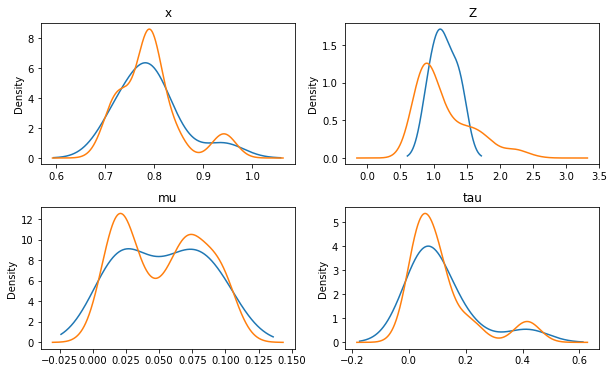

In [95]:
b = loss[(loss['class']=='vbPCA') & (loss['rotated']==True)]

fig, axs = plt.subplots(2, 2, figsize=(10, 6))
fig.subplots_adjust(hspace=.3)
b.groupby('data').mean()['x'].plot.kde(ax=axs[0, 0], title='x')
b['x'].plot.kde(ax=axs[0, 0])
b.groupby('data').mean()['Z'].plot.kde(ax=axs[0, 1], title='Z')
b['Z'].plot.kde(ax=axs[0, 1])
b.groupby('data').mean()['mu'].plot.kde(ax=axs[1, 0], title='mu')
b['mu'].plot.kde(ax=axs[1, 0])
b.groupby('data').mean()['tau'].plot.kde(ax=axs[1, 1], title='tau')
b['tau'].plot.kde(ax=axs[1, 1]);

#### Experiment 2



In [101]:
n_seed = 10
n_iter = 2000

d = tests.data().toy()
for i, cov in enumerate([
    {'posterior': 'fact', 'prior': {'W': 'full', 'Z': 'fact'}},
    {'posterior': 'fact', 'prior': {'W': 'fact', 'Z': 'full'}},
    {'posterior': 'fact', 'prior': {'W': 'full', 'Z': 'full'}},
    {'posterior': {'W': 'full', 'Z': 'fact'}, 'prior': {'W': 'full', 'Z': 'fact'}},
    {'posterior': {'W': 'fact', 'Z': 'full'}, 'prior': {'W': 'fact', 'Z': 'full'}},
    {'posterior': {'W': 'full', 'Z': 'full'}, 'prior': {'W': 'full', 'Z': 'full'}},
]):
    pca.probPCA.covariance = cov
    for s in range(n_seed):
        p1 = pca.probPCA(d.x1, seed=s, logdir='ppca_logs', covariance=i)
        p1.run(n_iter).critique(d, rotate=True)

2000/2000 [100%] ██████████████████████████████ Elapsed: 22s | Loss: 49969.297

data_loss: 0.5942004323005676
tau: 1.0579131841659546
alpha: nan
2000/2000 [100%] ██████████████████████████████ Elapsed: 21s | Loss: 49960.293

data_loss: 0.597918689250946
tau: 1.0576204061508179
alpha: nan
2000/2000 [100%] ██████████████████████████████ Elapsed: 22s | Loss: 50113.008

data_loss: 0.6276124715805054
tau: 1.1068236827850342
alpha: nan
2000/2000 [100%] ██████████████████████████████ Elapsed: 23s | Loss: 50800.020

data_loss: 0.4746206998825073
tau: 1.0513828992843628
alpha: nan
2000/2000 [100%] ██████████████████████████████ Elapsed: 23s | Loss: 50107.781

data_loss: 0.6348752379417419
tau: 1.1149816513061523
alpha: nan
2000/2000 [100%] ██████████████████████████████ Elapsed: 24s | Loss: 50532.410

data_loss: 0.5986787676811218
tau: 1.1120549440383911
alpha: nan
2000/2000 [100%] ██████████████████████████████ Elapsed: 25s | Loss: 49962.938

data_loss: 0.595693051815033
tau: 1.055461883544921

In [106]:
loss = p1.losses.replace('None', np.nan)

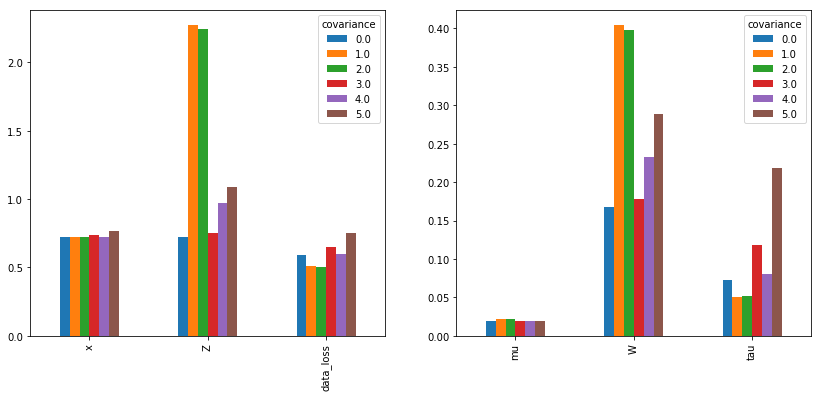

In [122]:
a = loss.groupby('covariance').mean()

fig, axs = plt.subplots(1, 2, figsize=(14, 6))
a[['x', 'Z', 'data_loss']].T.plot.bar(ax=axs[0])
a[['mu', 'W', 'tau']].T.plot.bar(ax=axs[1])

| |experiments|routines|changed|
|-|-|-|-|
|old|1|detPCA |data| 
| | |probPCA|seeds|
| | |vbPCA| |
| |2|probPCA|covariances|
| |3|probPCA|$\mu$ |
|new|1|probPCA|covariances, initialization|
| |2|probPCA|$\mu$, $\tau$|

#### Experiment 3

* with trainable hyper mean parameter in full mean prior (hyper = 1), or without hyperparametr (hyper = 0), but the same approximation to the posterior.

In [164]:
n_iter = 2000
n_seed = 10

for i in range(n_seed):
    for h in [False, True]:
        p1 = pca.probPCA(d.x1, logdir='ppca_logs', hyper=h, seed=i, mean='full').run(n_iter).critique(d, rotate=True)

2000/2000 [100%] ██████████████████████████████ Elapsed: 14s | Loss: 50532.742

data_loss: 2.5899457931518555
tau: 1.1778837442398071
alpha: nan
2000/2000 [100%] ██████████████████████████████ Elapsed: 14s | Loss: 53483.512

data_loss: 0.8312762379646301
tau: 0.962900698184967
alpha: nan
2000/2000 [100%] ██████████████████████████████ Elapsed: 14s | Loss: 50006.195

data_loss: 1.163772463798523
tau: 1.0601345300674438
alpha: nan
2000/2000 [100%] ██████████████████████████████ Elapsed: 14s | Loss: 49963.207

data_loss: 1.150828242301941
tau: 1.0577908754348755
alpha: nan
2000/2000 [100%] ██████████████████████████████ Elapsed: 15s | Loss: 49997.250

data_loss: 2.026425838470459
tau: 1.0601553916931152
alpha: nan
2000/2000 [100%] ██████████████████████████████ Elapsed: 15s | Loss: 50009.660

data_loss: 0.968409538269043
tau: 1.053971529006958
alpha: nan
2000/2000 [100%] ██████████████████████████████ Elapsed: 15s | Loss: 50104.125

data_loss: 1.4801851511001587
tau: 1.1250717639923096
al

In [150]:
loss.groupby('hyper').mean()

,W,Z,data_loss,missing,mu,n_iter,rotated,tau,x
hyper,,,,,,,,,
0.0,0.135271,0.736606,0.552601,0.0,0.019550,2000.0,1.0,0.087977,0.730375
1.0,0.069329,0.728824,0.602254,0.0,0.019638,2000.0,1.0,0.080287,0.722798


In [168]:
loss = p1.losses.copy()

In [181]:
# using hyper_mean as 'mu' in code (examples 20-29 in loss exp3)
n_iter = 2000
n_seed = 10

for i in range(n_seed):
    p1 = pca.probPCA(d.x1, logdir='ppca_logs', hyper=True, seed=i, mean='full').run(n_iter).critique(d, rotate=True)

2000/2000 [100%] ██████████████████████████████ Elapsed: 14s | Loss: 49930.047

data_loss: 1.1840087175369263
tau: 1.0572891235351562
alpha: nan
2000/2000 [100%] ██████████████████████████████ Elapsed: 14s | Loss: 49963.352

data_loss: 1.1057696342468262
tau: 1.0388433933258057
alpha: nan
2000/2000 [100%] ██████████████████████████████ Elapsed: 14s | Loss: 49921.203

data_loss: 0.9175814986228943
tau: 1.025883436203003
alpha: nan
2000/2000 [100%] ██████████████████████████████ Elapsed: 15s | Loss: 49906.555

data_loss: 1.274322509765625
tau: 1.026036262512207
alpha: nan
2000/2000 [100%] ██████████████████████████████ Elapsed: 15s | Loss: 49875.324

data_loss: 0.6064409613609314
tau: 1.0283000469207764
alpha: nan
2000/2000 [100%] ██████████████████████████████ Elapsed: 15s | Loss: 49888.566

data_loss: 1.699649691581726
tau: 1.0272717475891113
alpha: nan
2000/2000 [100%] ██████████████████████████████ Elapsed: 15s | Loss: 49950.516

data_loss: 0.7106978893280029
tau: 1.0258197784423828


In [199]:
loss.loc[:19].groupby('hyper').mean()

,W,Z,data_loss,missing,mu,n_iter,rotated,seed,tau,x
hyper,,,,,,,,,,
False,0.125339,0.726546,1.464006,0.0,0.020676,2000.0,1.0,4.5,0.069437,1.176685
True,0.105994,0.734648,1.564008,0.0,0.019680,2000.0,1.0,4.5,0.054362,1.295266


In [206]:
loss[loss.hyper][['mu', 'seed']].pivot(columns='seed')

mu                                                              \
seed      0.0       1.0       2.0       3.0       4.0       5.0       6.0   
1     0.01587       NaN       NaN       NaN       NaN       NaN       NaN   
3         NaN  0.017299       NaN       NaN       NaN       NaN       NaN   
5         NaN       NaN  0.019093       NaN       NaN       NaN       NaN   
7         NaN       NaN       NaN  0.019177       NaN       NaN       NaN   
9         NaN       NaN       NaN       NaN  0.020905       NaN       NaN   
11        NaN       NaN       NaN       NaN       NaN  0.021215       NaN   
13        NaN       NaN       NaN       NaN       NaN       NaN  0.020919   
15        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
17        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
19        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
20    0.02478       NaN       NaN       NaN       NaN       NaN       NaN   
21        NaN  0.023169       NaN       NaN       NaN       NaN       NaN   
22        NaN       NaN  0.020727       NaN       NaN       NaN       NaN   
23        NaN       NaN       NaN  0.021749       NaN       NaN       NaN   
24        NaN       NaN       NaN       NaN  0.017747       NaN       NaN   
25        NaN       NaN       NaN       NaN       NaN  0.022393       NaN   
26        NaN       NaN       NaN       NaN       NaN       NaN  0.022175   
27        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
28        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
29        NaN       NaN       NaN       NaN       NaN       NaN       NaN   

                                    
seed       7.0       8.0       9.0  
1          NaN       NaN       NaN  
3          NaN       NaN       NaN  
5          NaN       NaN       NaN  
7          NaN       NaN       NaN  
9          NaN       NaN       NaN  
11         NaN       NaN       NaN  
13         NaN       NaN       NaN  
15    0.022647       NaN       NaN  
17         NaN  0.021207       NaN  
19         NaN       NaN  0.018472  
20         NaN       NaN       NaN  
21         NaN       NaN       NaN  
22         NaN       NaN       NaN  
23         NaN       NaN       NaN  
24         NaN       NaN       NaN  
25         NaN       NaN       NaN  
26         NaN       NaN       NaN  
27    0.023333       NaN       NaN  
28         NaN  0.014967       NaN  
29         NaN       NaN  0.024742

In [307]:
S = pd.HDFStore('../python/pca/exp.h5')

In [127]:
config = core.probPCA.configure(True)

In [121]:
def color_table(data, shape, hl=4):
    a = np.repeat(['background-color: none'], shape)
    a[hl] = 'background-color: red'
    return a

### Defaults

* $\mu$ and $\tau$ are by default ('none' as kwargs in init) set to the **posterior** values in the config table
    * <span style='color:red'>$\mu$ to the **loc** value and $\tau$ to the **scale** value</span>
* otherwise (```tau = 'full'``` in instantiation), $\tau$ is prior is a fixed Gamma and posterior is always trainable, but its initialization can be set
* $\mu$ prior and posterior are set to the table values (if ```mu = 'full'```)


#### useful link:
[pandas styling](https://pandas.pydata.org/pandas-docs/stable/style.html)

In [133]:
config.style.apply(color_table, shape=table.shape[0], red=[4, 7], axis=0)

In [153]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

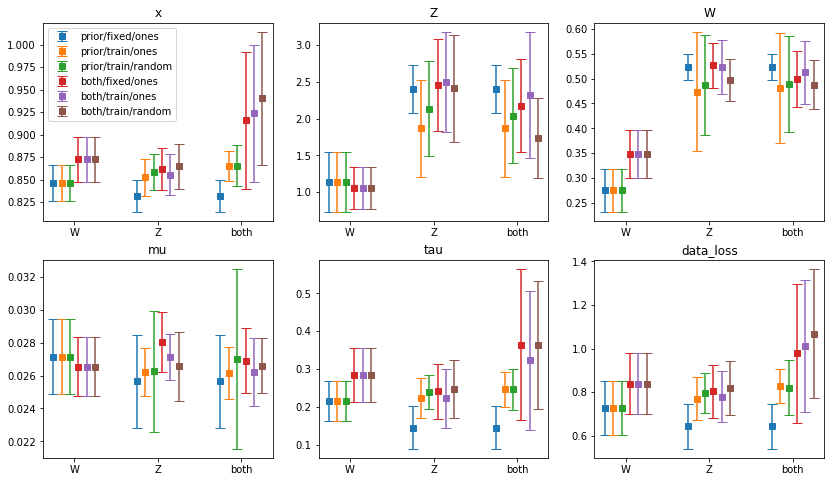

In [287]:
fig, axs = plt.subplots(2, 3, figsize=(14, 8))

for k, x in enumerate(['x', 'Z', 'W', 'mu', 'tau', 'data_loss']):
    i = k // 3
    j = k % 3
    epl(axs[i, j], loss, x, -.25, covariance=[0,1,2], initialization=[0], label='prior/fixed/ones')
    epl(axs[i, j], loss, x, -.15, covariance=[0,1,2], initialization=[1], label='prior/train/ones')
    epl(axs[i, j], loss, x, -.05, covariance=[0,1,2], initialization=[2], label='prior/train/random')
    epl(axs[i, j], loss, x, .05, covariance=[3,4,5], initialization=[0], label='both/fixed/ones')
    epl(axs[i, j], loss, x, .15, covariance=[3,4,5], initialization=[1], label='both/train/ones')
    epl(axs[i, j], loss, x, .25, covariance=[3,4,5], initialization=[2], label='both/train/random')
    axs[i, j].set_xticklabels(['W','Z','both'])

axs[0, 0].legend(); #loc='upper left', bbox_to_anchor=(1, 1));

### Effect of convergence measure

* `exp3` uses data_loss.std() (over 100 iterations) < 1e-4 as measure for convergence
* I accidentally run the first experiment twice (with different data), hence the two colors

In [4]:
S = pd.HDFStore('../python/pca/exp3.h5')

In [90]:
with pd.HDFStore('../python/pca/convergence_tests.h5') as C:
    loss3 = C['test3']
    loss4 = C['test4']

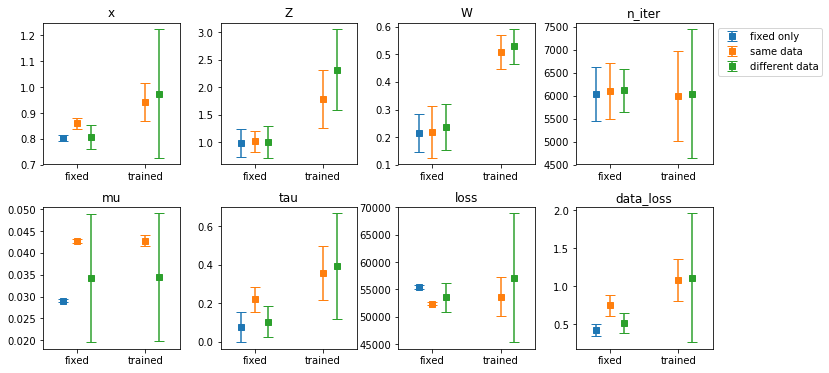

In [97]:
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
fig.subplots_adjust(hspace=0.3, wspace=.3)
dat = loss3.data.unique()

for k, x in enumerate(['x', 'Z', 'W', 'n_iter', 'mu', 'tau', 'loss', 'data_loss']):
    i = k // 4
    j = k % 4
    epl(axs[i, j], loss3, x, -.2, covariance=[0,1], data=[dat[0]], label='fixed only')
    epl(axs[i, j], loss3, x, covariance=[0,1], data=[dat[1]], label='same data')
    epl(axs[i, j], loss4, x, .2, covariance=[0,1], label='different data')
    axs[i, j].set_xticklabels(['fixed', 'trained'])
    axs[i, j].set_xlim([-.5, 1.5])
axs[0, 3].legend(loc='upper left', bbox_to_anchor=(1, 1));

# Tests with full system (tests.py)

In some places, I compare two different versions of the [TensorFlow](https://www.tensorflow.org/api_docs/)-based scheme, corresponding to two branches of the git repo: 
1. **'old'**: Here the data is loaded into the graph on construction, so that the graph needs to be reconstructed every time new data is used. (Tests are in pca/convergence.h5)
2. **'master'**: Here, graph construction and data are separated by means of tf.placeholder use. This is now the master branch, (Tests are in pca/convergence2.h5)

## Convergence

[Edward](http://edwardlib.org) has two methods available for [KLqp](http://edwardlib.org/api/ed/KLqp) divergence:
1. score function gradients <cite data-cite="2031184/HCD9LGWZ"></cite>
1. reparameterization gradients <cite data-cite="2031184/MTAV2HE4"></cite>

The variance of the loss function is related to the number of samples (``n_samples`` in ``initialize()``).

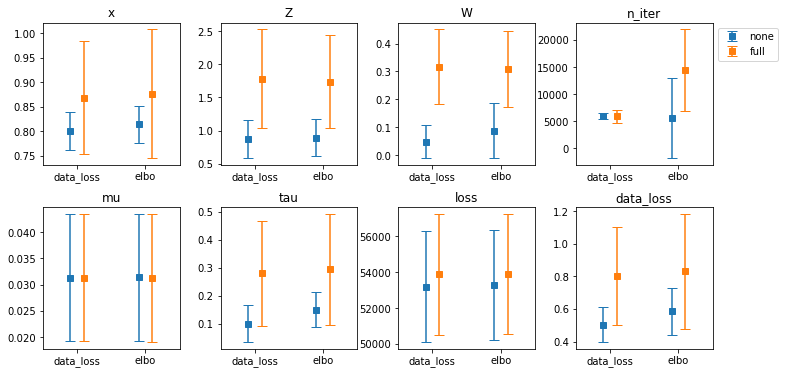

In [109]:
# 'master' branch

fig, axs = plt.subplots(2, 4, figsize=(12, 6))
fig.subplots_adjust(hspace=0.3, wspace=.3)

for k, x in enumerate(['x', 'Z', 'W', 'n_iter', 'mu', 'tau', 'loss', 'data_loss']):
    i = k // 4
    j = k % 4
    epl(axs[i, j], results, x, -.1, covariance=['none'], convergence_test=['data_loss', 'elbo'])
    epl(axs[i, j], results, x, .1, covariance=['full'], convergence_test=['data_loss', 'elbo'])
    axs[i, j].set_xlim([-.5, 1.5])
axs[0, 3].legend(loc='upper left', bbox_to_anchor=(1, 1));

In [66]:
from pca.tests import Test

In [67]:
test = Test('../python/pca/convergence2.h5', 'data_loss_vs_elbo', plot=True)

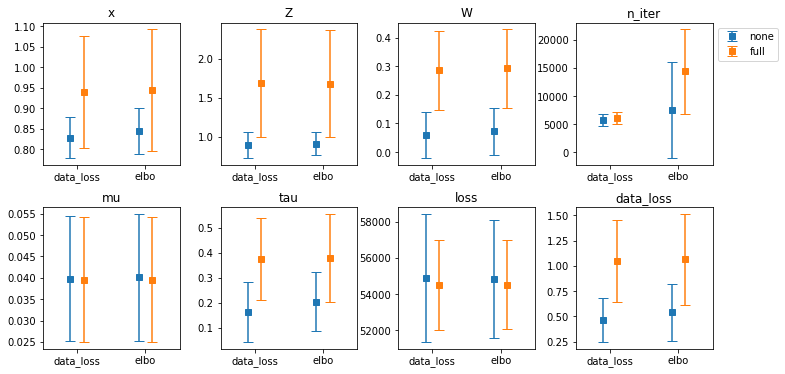

In [70]:
# 'pca_tf_placeholder' branch

axs = test.plot('convergence_test', {'covariance': ['none', 'full']})
axs[0, 3].legend(loc='upper left', bbox_to_anchor=(1, 1));

Losses evaluated for the individual components of the PCA decomposition in depence of:   
**x-axis:** measure used for evaluating convergence   
**color:** posterior approximation to the ``W`` and ``Z`` matrices (factorized or full covariance).

Each of the four groups contains 100 samples of 10 different random data instances and 10 different seeds for the variable initialization.

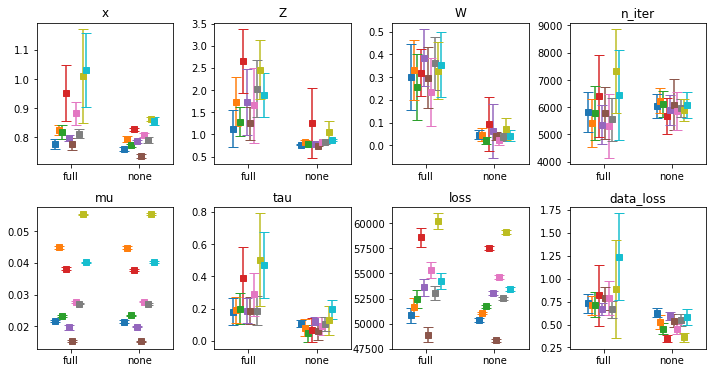

In [110]:
# 'master' branch

fig, axs = plt.subplots(2, 4, figsize=(12, 6))
fig.subplots_adjust(hspace=0.3, wspace=.3)
data = results.data_id.unique()

for k, x in enumerate(['x', 'Z', 'W', 'n_iter', 'mu', 'tau', 'loss', 'data_loss']):
    i = k // 4
    j = k % 4
    for l, d in enumerate(data):
        epl(axs[i, j], results, x, (l-4.5)/20, covariance=['none', 'full'], convergence_test=['data_loss'], data_id=[d])
    axs[i, j].set_xlim([-.5, 1.5])

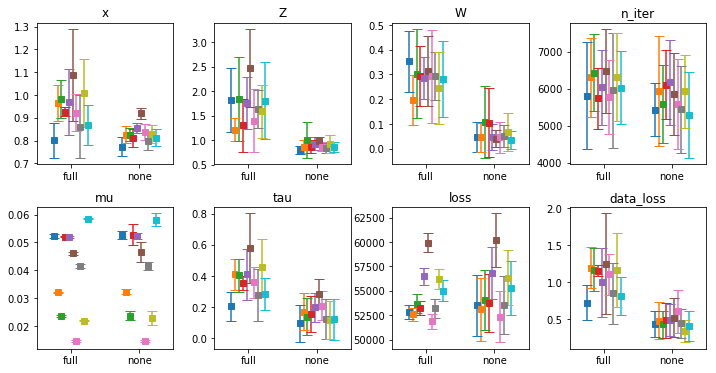

In [71]:
# 'pca_tf_placeholder' branch

axs = test.plot({'covariance': ['none', 'full']}, 'data_id', convergence_test=['data_loss'])

**Only data_loss as convergence measure.** Colors denote different data instances (i.e. the spread is over different initial seeds).

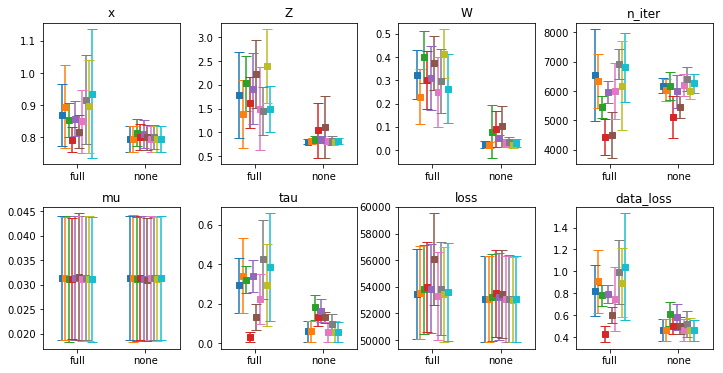

In [111]:
# 'master' branch

fig, axs = plt.subplots(2, 4, figsize=(12, 6))
fig.subplots_adjust(hspace=0.3, wspace=.3)
seed = results.seed.unique()

for k, x in enumerate(['x', 'Z', 'W', 'n_iter', 'mu', 'tau', 'loss', 'data_loss']):
    i = k // 4
    j = k % 4
    for l, s in enumerate(seed):
        epl(axs[i, j], results, x, (l-4.5)/20, covariance=['none', 'full'], convergence_test=['data_loss'], seed=[s])
    axs[i, j].set_xlim([-.5, 1.5])

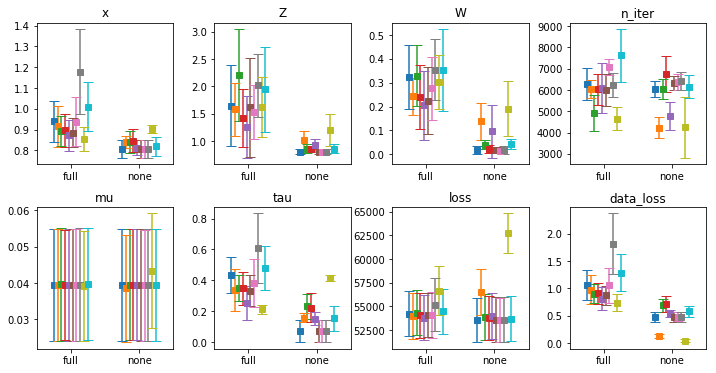

In [72]:
# 'pca_tf_placeholder' branch

axs = test.plot({'covariance': ['none', 'full']}, 'seed', convergence_test=['data_loss'])

**Only data_loss as convergence measure.** Colors denote different random seeds for initialization (i.e. the spread is over different data).

There is a substantial fraction of runs that did not converge according to the 'elbo' measure.

In [24]:
results[results.n_iter==20000].groupby('convergence_test').count()

,W,Z,class,covariance,data_id,data_loss,logs,loss,missing,mu,n_iter,rotated,seed,tau,x
convergence_test,,,,,,,,,,,,,,,
elbo,89,89,89,89,89,89,0,89,89,89,89,89,89,89,89


**REMEMBER** to check for the n_iter=20000 runs

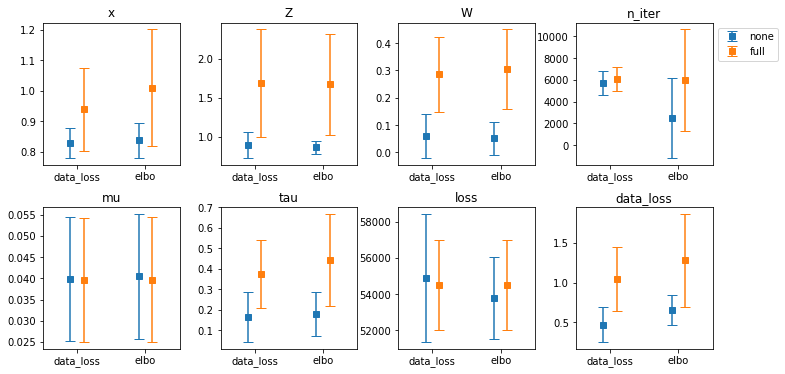

In [79]:
# 'pca_tf_placeholder' branch

axs = test.plot('convergence_test', {'covariance': ['none', 'full']}, results=results[results.n_iter!=20000])
axs[0, 3].legend(loc='upper left', bbox_to_anchor=(1, 1));

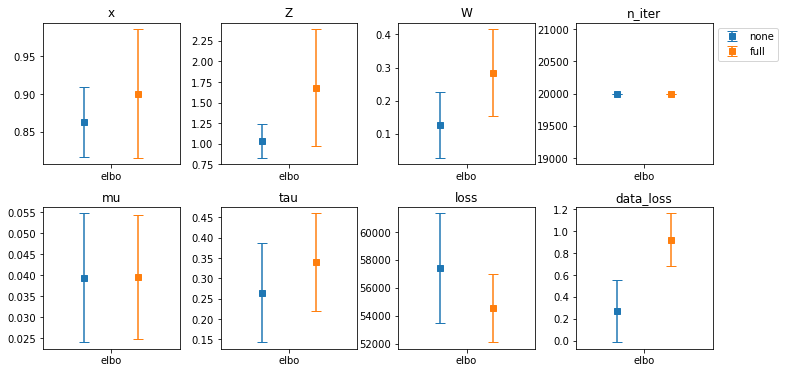

In [81]:
# 'pca_tf_placeholder' branch

axs = test.plot('convergence_test', {'covariance': ['none', 'full']}, results=results[results.n_iter==20000])
axs[0, 3].legend(loc='upper left', bbox_to_anchor=(1, 1));

In [137]:
test = tests.Test('../python/pca/covariance.h5', 'covariance_variations', plot=True)

In [86]:
(test.results.n_iter==20000).sum()

508

## Variations in estimation of $\mu$ and $\tau$

### $\mu$ variations

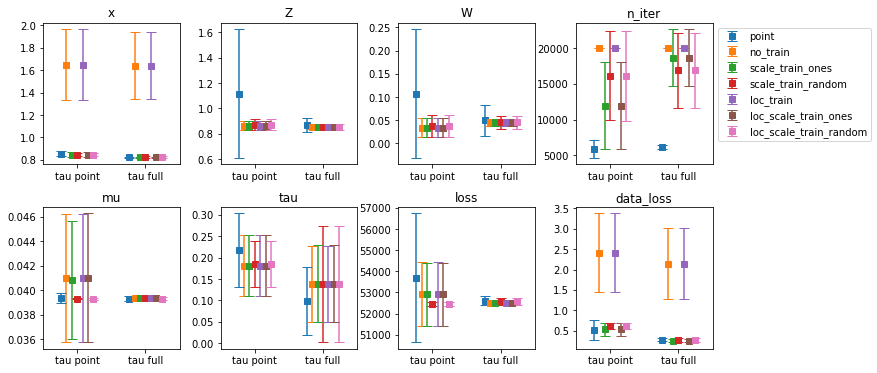

In [101]:
axs = test.plot('l', 'mu_variations', xlabels=['tau point', 'tau full'])
axs[0, 3].legend(loc='upper left', bbox_to_anchor=(1, 1));

#### Observations:
1. The runs which don't converge with 20,000 iterations are the ones which don't allow training in one or both variables. However it seems more the scale is what needs training. (??)
1. The outlier is generally the point estimation of $\mu$.
1. Scale initialization with ``tf.ones`` needs a lower number of iterations, but that's to be expected given that the 'true' scale is 1.

#### Note:
The alternatives to the point estimation differ only in the specification of the prior, i.e. whether the prior is fixed to some value or itself contains hyperparamteters that are trainable. If the prior is set not to train, it is set to
$$
\mu \sim \mathcal{N}\left(\mu; m, \nu_{\mu} \mathbf{I}\right)
$$
where $m$ is the 'data_mean' and $\nu_{\mu} = 1$

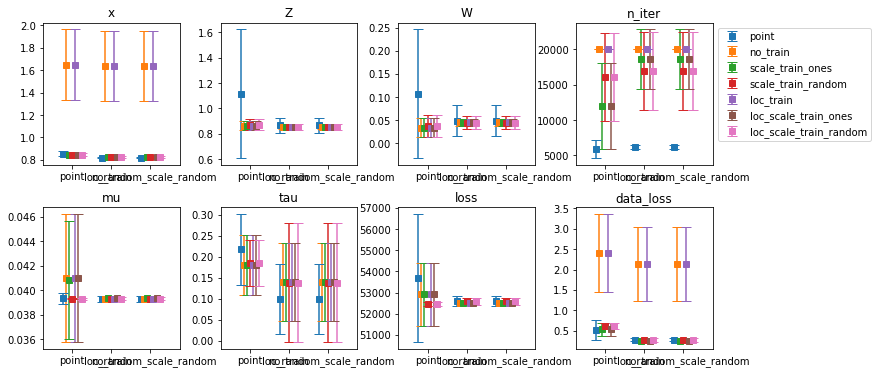

In [146]:
axs = test.plot({'tau_variations':['point', 'no_train', 'loc_random_scale_random']}, 'mu_variations')
axs[0, 3].legend(loc='upper left', bbox_to_anchor=(1, 1));

### $\tau$ variations

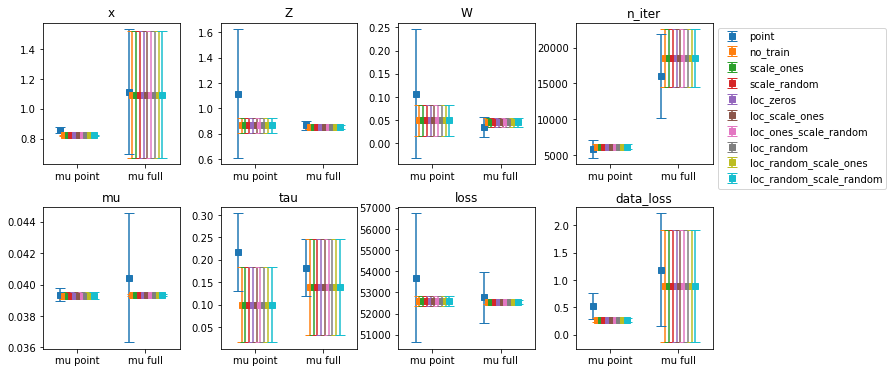

In [108]:
axs = test.plot('i', 'tau_variations', xlabels=['mu point', 'mu full'])
axs[0, 3].legend(loc='upper left', bbox_to_anchor=(1, 1));

#### Observations:
1. Again, point estimation appears to fare worse. 
1. $\mu$ ``full``'s wide range of errors may be because it comprises all of the cases of trainability, including the ones that don't converge. In fact, **see below**: The error in the ``full`` $\mu$ cases seems to emenate mostly from the ``no train`` cases.
1. Otherwise there seems little difference in how we specify the prior for $\tau$, not even for no trainability - but that might be because the noise level is fixed in the data at 1.

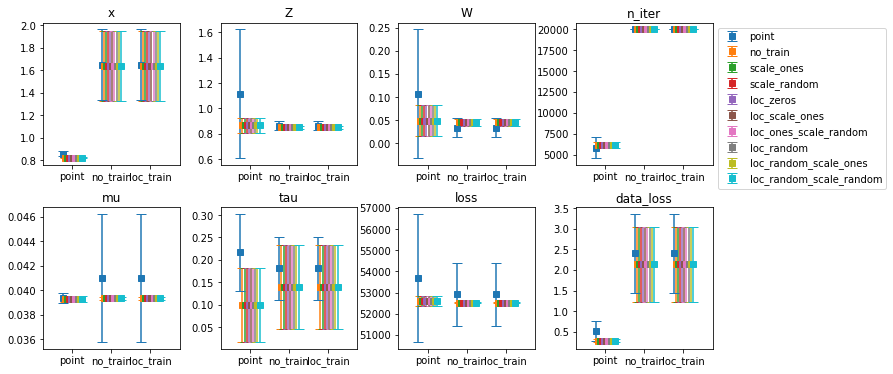

In [141]:
axs = test.plot({'mu_variations':['point', 'no_train', 'loc_train']}, 'tau_variations')
axs[0, 3].legend(loc='upper left', bbox_to_anchor=(1, 1));

#### Observations:
1. Point estimation in both variables seems to concurr with generally larger errors, except in $\mu$ itself.
2. In general, the error due to point estimation is more pronounced in the principal component variables, $W$ and $Z$. This seems to imply some sort of tradeoff between where the algorithm allocates weights and uncertainty.

**Question:   
Do the better results in $W$ and $Z$ with a full-prior $\mu$ and $\tau$ imply that full Bayesian treatment takes better account of the uncertainties?** (The $\mu$ use in the data generation has a distribution.) 

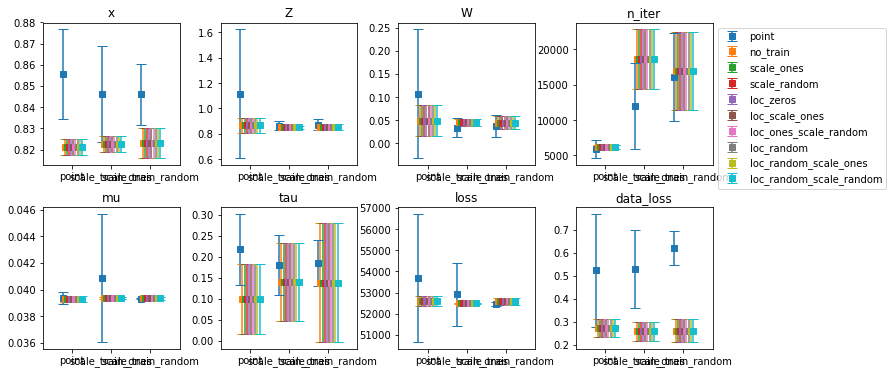

In [138]:
axs = test.plot({'mu_variations':['point', 'scale_train_ones', 'scale_train_random']}, 'tau_variations')
axs[0, 3].legend(loc='upper left', bbox_to_anchor=(1, 1));

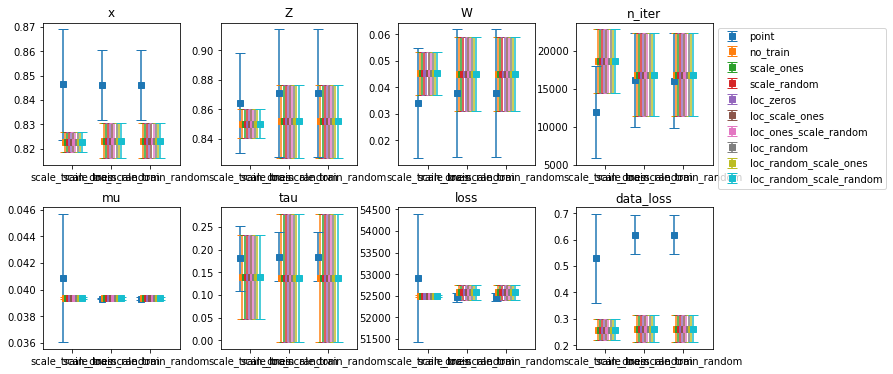

In [142]:
axs = test.plot({'mu_variations':['scale_train_ones', 'scale_train_random', 'loc_scale_train_random']}, 'tau_variations')
axs[0, 3].legend(loc='upper left', bbox_to_anchor=(1, 1));

### Conclusions
1. make $\mu$ and $\tau$ trainable and fully Bayesian. The nature of initialization is more relevant for number of iterations needed than for results.
2. $\mu$ scale is more relvant than $\mu$ location, but then, the location is always initialized from data means.
3. With $\tau$, a Bayesian treatment appears to be better than point estimation.

### NOTE:
The $\tau$ prior is unchanging anyway, that's why the results are all the same, i.e. if $\tau$ is ``full`` estimated, its prior is always
$$
\tau \sim \Gamma(\tau; 1 \times 10^{-5}, 1 \times 10^{-5}).
$$


I make the default configuration for the priors over $\mu$ and $\tau$ now Bayesian and trainable:

In [150]:
core.probPCA.configure(display=True)

trainable initializer
posterior W   loc         True      random
              scale       True      random
          Z   loc         True      random
              scale       True      random
          mu  loc         True      random
              scale       True      random
          tau loc         True      random
              scale       True      random
prior     W   loc        False       zeros
              scale      False        ones
          Z   loc        False       zeros
              scale      False        ones
          mu  loc         True   data_mean
              scale       True      random
          tau loc         True      random
              scale       True      random